In [1]:
# IMPORTS

#---------------------------------------------
# Standard libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import matplotlib as mpl
from matplotlib import ticker

#---------------------------------------------
# Specific libraries
from scipy import signal # Signal analysis
# Math utils
import math
# To measure execution times
from tqdm import tqdm
# Integration
from scipy.integrate import quad
# Roots finding
from scipy.optimize.elementwise import  find_root

#---------------------------------------------
# Files managing
import os
import pickle

#---------------------------------------------
# Animations
import imageio.v2 as iio

In [2]:
# Plots customization

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['font.size'] = 20

mpl.rcParams['lines.linewidth'] = 3

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['xtick.minor.pad'] = 4.5

mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['ytick.minor.pad'] = 4.5

mpl.rcParams['legend.frameon'] = False

In [3]:
# INPUT READING FUNCTIONS (NBODY_SH1)

#---------------------------------------------
# Read the input file:
#
# N = number of particles
# t_0 = initial time
# particles_0 = collection of mass + 6D position/velocity vector for every particle in the system
# The shape of particles is: [[m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1], 
#                             [m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2],
#                             ...,
#                             [m_N x_N, y_N, z_N, vx_N, vy_N, vz_N]]
#
# Returns:
#         a snapshot ("snapshot_0") of the system at the initial condition in the shape:
#         [N, t_0, particles_0] :   [N, t_0, [[m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1], 
#                                             [m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2],
#                                             ...,
#                                             [m_N x_N, y_N, z_N, vx_N, vy_N, vz_N]]]
#
# Input file is structured as follow:
#
# N
# t_0
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
def read_input_nbodysh1(input_file_path):
    input_file = open(input_file_path)

    # readline() reads the first line and returns it as a string
    N = int(input_file.readline())
    t_0 = float(input_file.readline())

    # readlines() reads all the remaining lines and returns them into a list of strings
    particles_0 = input_file.readlines()

    input_file.close()

    # Convert the list of strings into a list of lists of number
    for i in range(len(particles_0)):
        # split() splits a string based on a separator (default is ' ') and returns a list of strings
        particles_0[i] = particles_0[i].split()

        # Convert the elements of each splitted string into numbers
        for j in range(len(particles_0[i])):
            particles_0[i][j] = float(particles_0[i][j])

    snapshot_0 = [N, t_0, particles_0]

    return snapshot_0

#-----------------------------------------------------------------------------
# Read the output file:
# Output file is structured as follow:
#
# N
# t_1
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
# N
# t_2
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
#
# ...
#
# N
# t_f
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
#
# Returns a list of snapshot of the evolved system (t>t_0)
# See read_input for details on the snapshots
def read_output_nbodysh1(output_file_path):
    output_file = open(output_file_path)

    # List to store all the snapshots in the output file
    snapshots = []

    # Try except here detects the EOF
    # int() throws an exception when tries to convert something different than a number
    while True:
        try:
            N = int(output_file.readline())
        except:
            break

        # Line after N is the time stamp of the snapshot
        t_stamp = float(output_file.readline())

        # Collect strings of mass + 6D position/velocity vector N times (for N particles)
        particles = [output_file.readline() for i in range (N)]

        # Convert the list of strings into a list of lists of number (same as for read_input())
        for i in range(len(particles)):
            particles[i] = particles[i].split()

            for j in range(len(particles[i])):
                particles[i][j] = float(particles[i][j])
        
        # Append the snapshot [N, t_stamp, particles] to the snapshots list
        snapshots.append([N, t_stamp, particles])

    output_file.close()
    
    return snapshots

#--------------------------------------------------------------------------
# Returns the complete list of snapshots of the system (including the initial one)
#
# How to navigate the snapshots:
# 1) Choose the snapshot:
#    *** snapshots[snapshot_index, from 0 to len(snapshot)-1] ***
#
# 2) What do you want?
#    A) Number of particles:
#       *** snapshot[snapshot_index][0] ***
#       Note that snapshot[snapshot_index][0] can't be subscripted anymore
#
#    B) Time stamp: 
#       *** snapshot[snapshot_index][1] ***
#       Note that snapshot[snapshot_index][1] can't be subscripted anymore
#
#    C) Particles masses, positions and velocities:
#       *** snapshot[snapshot_index][2] ***
#       This is a list of lists (see read_input() for details)
#
# 3) Which particle are you interested in?
#    *** snapshot[snapshot_index][2][particle_index, from 0 to N-1] ***
#
# 4) What do you want to know about the particle:
#    *** Mass: snapshot[snapshot_index][2][particle_index][0] ***
#    *** x, y, z: snapshot[snapshot_index][2][particle_index][1, 2, 3] ***
#    *** vx, vy, vz: snapshot[snapshot_index][2][particle_index][1+3, 2+3, 3+3] ***
def read_snapshots_nbodysh1(input_file_path, output_file_path):
    snapshot_0 = read_input_nbodysh1(input_file_path)
    snapshots = read_output_nbodysh1(output_file_path)

    # Append the intial snapshot to the beginning of the list
    snapshots = [snapshot_0] + snapshots

    return snapshots

In [4]:
# INPUT READING FUNCTIONS (TREECODE)

#---------------------------------------------
# Input and output files for the treecode program are different than those for nbody_sh1
# Nevertheless the output of the reading functions have the same shape of those for the nbody_sh1
# There are just small variations depending on the parameters: include_ndim and contains_pot
# Read the explanations for the details. Refer to nbody_sh1 i/o functions for reference about
# how 'snapshots' works

#---------------------------------------------
# read_input_treecode() is just for completeness since the treecode program appends
# the initial snapshot at the beginning of the output file, as opposed to the nbody_sh1 program
# Read it for reference for read_output_treecode()
# Input file is structured as follow:
#
# N
# n_dim
# t_0
# m_1
# ..
# m_N
# x_1, y_1, z_1
# ...
# x_N, y_N, z_N
# vx_1, vy_1, vz_1
# ...
# vx_N, vy_N, vz_N
def read_input_treecode(input_file_path, include_ndim=False):
    input_file = open(input_file_path)

    # readline() reads the first line and returns it as a string
    N = int(input_file.readline())
    n_dim = int(input_file.readline())
    t_0 = float(input_file.readline())

    masses = []
    positions = []
    velocities = []

    # Works like this: data[quantity][particle]
    data = [masses, positions, velocities]

    for i in range(3):
        for j in range(N):
                data[i].append(input_file.readline())
                # split() splits a string based on a separator (default is ' ') and returns a list of strings
                data[i][j] = data[i][j].split()
                # Convert the elements of each splitted string into numbers
                for k in range(len(data[i][j])):
                    data[i][j][k] = float(data[i][j][k])

    # At this point 'data' works like this: data[quantity][particle_index][quantity_index]
    #                                       quantity: 0, 1, 2 (mass, positions, velocities)
    #                                       particle: 0, 1, 2, ..., N-1
    #                                       quantity_index: just 0 if quantity = 0
    #                                                       0, 1, 2 (x, y, z) if quantity = 1
    #                                                       0, 1, 2 (vx, vy, vz) if quantity = 2
    input_file.close()

    # Populate 'particles_0' by cycling over 'data'
    particles_0 = []

    for j in range(N):
        particle_0 = []
        for i in range(3):
            for k in range(len(data[i][j])):
                particle_0.append(data[i][j][k])
        particles_0.append(particle_0)

    # Wether to include n_dim in the snapshot or not
    if include_ndim:
        snapshot_0 = [N, t_0, particles_0, n_dim]
    else:
        snapshot_0 = [N, t_0, particles_0]

    return snapshot_0

#-----------------------------------------------------------------------------
# Read the output file:
# Output file is structured like the input file, but for the fact the structure
# is repeated for every time.
# See read_input() for details
# Returns a list of snapshot of the evolved system (t>t_0)
# If contains_pot=True then to each particle also its potential energy is attached at index 7
# If save_pkl=True then the created snapshots instance is saved as a .pkl file
# If import_pkl=True then try to read the file corresponding to
# output_file_path but with the .pkl extension
# If the file exists and both 'import_pkl' and 'save_pkl' are set to True, then
# the snapshots are read but they won't get resaved
# The contains_pot parameter doesn't affect the behavior while saving or importing,
# it only affects reading.
def read_output_treecode(output_file_name, include_ndim=False, contains_pot=False,
                         save_pkl=False, import_pkl=True):
    files_dir_path = 'data_results'
    file_name = os.path.basename(output_file_name) + '.pkl'
    file_path = os.path.join(files_dir_path, file_name)

    if not import_pkl:
        output_file_name = output_file_name + '.txt'
        # Get the total number of lines
        with open(output_file_name) as output_file:
            total_lines = sum(1 for line in output_file)

        # List to store all the snapshots in the output file
        snapshots = []

        with open(output_file_name) as output_file:
            with tqdm(total=total_lines,
                    desc='read_output_treecode(contains_pot={})'.format(contains_pot)) as pbar:
                # Try except here detects the EOF
                # int() throws an exception when tries to convert something different than a number
                while True:
                    try:
                        N = int(output_file.readline())
                        lines_read = 1
                    except:
                        break
                    
                    # LIKE read_input() START
                    
                    n_dim = int(output_file.readline())
                    t_stamp = float(output_file.readline())
                    lines_read += 2

                    masses = []
                    positions = []
                    velocities = []
                    potentials = []

                    if contains_pot:
                        data = [masses, positions, velocities, potentials]
                    else:
                        data = [masses, positions, velocities]

                    for i in range(len(data)):
                        for j in range(N):
                            data[i].append(output_file.readline())
                            lines_read += 1
                            data[i][j] = data[i][j].split()
                            for k in range(len(data[i][j])):
                                data[i][j][k] = float(data[i][j][k])
                    
                    particles = []

                    for j in range(N):
                        particle = []
                        for i in range(len(data)):
                            for k in range(len(data[i][j])):
                                particle.append(data[i][j][k])
                        particles.append(particle)

                    # LIKE read_input() END
                    
                    # Append the snapshot [N, t_stamp, particles] to the snapshots list
                    if include_ndim:
                        snapshots.append([N, t_stamp, particles, n_dim])
                    else:
                        snapshots.append([N, t_stamp, particles])

                    # Update the progress bar
                    pbar.update(lines_read)
        if save_pkl:
            print("Exporting snapshots")
            os.makedirs(files_dir_path, exist_ok=True)
            with open(file_path, "wb") as f:
                pickle.dump(snapshots, f)
    else:
        if os.path.isfile(file_path):
            print("Importing snapshots")
            with open(file_path, "rb") as f:
                snapshots = pickle.load(f)
        else:
            snapshots = read_output_treecode(output_file_name, include_ndim, contains_pot, save_pkl, False)
    
    return snapshots

In [5]:
# MATHEMATICAL FUNCTIONS

#-------------------------------------------------------------------------
# Returns the difference between two vectors (vector_2 - vector_1)
# 
# If vectors are positions:
# It is a vector that points from position_1 to position_2: [x_2 - x_1, y_2 - y_1, z_2 - z_1]
# 
# If vectors are velocities:
# It is a vectors that describes the relative velocity in the frame in which particle 1 is at rest
# [vx_2 - vx_1, vy_2 - vy_1, vz_2 - vz_1]
#
# Imput parameters should be strictly numpy arrays of 3 numbers: (x, y, z)
def compute_vector_diff(vector_1, vector_2):
    return vector_2 - vector_1

# Returns the vectorial product of two vectors
# Imput parameters are strictly numpy arrays of 3 numbers: (x, y, z)
#
# Use NP.CROSS() for a safe and complete implementation
def compute_vectorial_product(vector_1, vector_2):
    x = vector_1[1] * vector_2[2] - vector_1[2] * vector_2[1]
    y = vector_1[2] * vector_2[0] - vector_1[0] * vector_2[2]
    z = vector_1[0] * vector_2[1] - vector_1[1] * vector_2[0]

    return np.array([x, y, z])

# Returns the absolute value of a vector to the absval-th power
def compute_vector_abs(vector, absval=1):
    value = 0

    for i in range(len(vector)):
        value += vector[i] ** 2
    
    # Don't waste computational power if you want the square of the vector
    if absval == 2:
        pass
    else:
        value = value ** (absval / 2)

    return value

# Returns the distance between two points
# Imput parameters are arrays of 3 numbers: (x, y, z)
def compute_distance(point_1, point_2):
    distance = 0
    for i in range (3):
        distance += (point_1[i] - point_2[i]) ** 2
    
    return distance ** (1 / 2)

In [6]:
# COORDINATES FUNCTIONS

#----------------------------------------------------------------
# Returns the 3D vector (x, y, z) correspoding to the spherical_coordinates (r, theta, phi)
# Imput parameter is strictly a numpy array of 3 numbers: (r, theta, phi)
def spherical_to_cartesian(spherical_coordinates):
    r = spherical_coordinates[0]
    theta = spherical_coordinates[1]
    phi = spherical_coordinates[2]

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # Floating point precision would not give exact results around zeros of goniometric functions
    return np.array([x, y, z])

# Returns the 3D vector (r, theta, phi) correspoding to the cartesian_coordinates (x, y, z)
# Imput parameter is strictly a numpy array of 3 numbers: (x, y, z)
def cartesian_to_spherical(cartesian_coordinates):
    x = cartesian_coordinates[0]
    y = cartesian_coordinates[1]
    z = cartesian_coordinates[2]

    r = ((x ** 2) + (y ** 2) + (z ** 2)) ** (1 / 2)

    if x == 0 and y == 0 and z == 0:
        theta = None
    else:
        theta = np.arccos(z / r)

    if x == 0 and y == 0:
        phi = None
    else:
        phi = np.arccos(x / (r * np.sin(theta)))
        if y < 0:
            phi = 2 * np.pi - phi
    
    # Floating point precision would not give exact results around zeros of goniometric functions
    return np.array([r, theta, phi])

In [7]:
# SNAPSHOTS READING FUNCTIONS & SMALL CALCULATIONS

#------------------------------------------------------------------
# Reads an 'indexes' parameter and converts it into a numpy array
# 'indexes' can be an integer, a numpy array (of specified indexes) or 'all'
# If indexes='all', also 'all_number' must be specified; it is the lenght of
# the list of all indexes. It must be > 0
# Returns a numpy array containing the required indexes
def indexes_par_reader(indexes, all_number=None):
    # If indexes = 'all', get all indexes
    if (type(indexes) == str and indexes == 'all' and
        (type(all_number) == int or type(all_number) == np.int_) and all_number > 0):
        _indx = np.array(range(all_number))

    # If 'indexes' is an integer, make an array of one element containing it
    elif type(indexes) == int or type(indexes) == np.int_:
        _indx = np.array([indexes])
    
    # If 'indexes' is already a 1 dimension numpy array, return it as it is
    elif (type(indexes) == np.ndarray) and (indexes.ndim == 1):
        _indx = np.copy(indexes)

    return _indx
    
# Returns an array of the number of particles of the snapshots
def get_N(snapshots):
    return np.array([snapshots[i][0] for i in range(len(snapshots))])

# Returns an array of the time stamps of the snapshots
def get_timestamps(snapshots):
    return np.array([snapshots[i][1] for i in range(len(snapshots))])

# Returns an array of the specified masses at the specified times
# If total=True returns the total mass
# particle_indexs are the indexes of the masses to consider
# time_indexes are the indexes of the snapshot times to consider
# They can be numpy arrays, single integer values or 'all'
#
# *** WARNINGS ***
#
# See *** WARNINGS *** in get_3d_vec()
def get_masses(snapshots, particle_indexes, total=False, time_indexes=0):
    # See get_3d_vec() for explanation
    T_indx = indexes_par_reader(time_indexes, len(snapshots))

    if type(time_indexes) == int or type(time_indexes) == np.int_:
        P_indx = indexes_par_reader(particle_indexes, len(snapshots[time_indexes][2]))
    else:
        P_indx = indexes_par_reader(particle_indexes, snapshots[0][0])

    masses = np.zeros((len(T_indx), len(P_indx)))

    for r_t_i, time_index in zip(range(len(T_indx)), T_indx):
        for r_p_i, particle_index in zip(range(len(P_indx)), P_indx):
            masses[r_t_i][r_p_i] = snapshots[time_index][2][particle_index][0]
        if total:
            masses[r_t_i] = np.sum(masses[r_t_i])

    if total:
        masses = np.delete(masses, slice(1, len(P_indx)), axis=1)

    if masses.shape == (1, 1):
        return masses[0][0]
    else:
        return np.squeeze(masses)

# Compute the position or velocity of the center of mass for the specified times
# Returns an array with shape: [[qt_x, qt_y, qt_z]_ti_0, ..., [qt_x, qt_y, qt_z]_ti_(len(time_indexes)-1)]
# vec = 'pos', 'vel'
# time_indexes are the indexes of the snapshot that will be taken into account
# particle_indexs are the indexes of the masses to consider
# They can be numpy arrays, single integer values or 'all'
#
# use_stored: whether to use the saved values or not
# save: wheter to save the computed results or not
# If the file exists and both 'use_stored' and 'save' are set to True, then
# the results are read but they won't get resaved
#
# *** WARNINGS ***
#
# See *** WARNINGS *** in get_3d_vec()
def get_center_of_mass(snapshots, time_indexes, vec='', particle_indexes='all',
                       use_stored=True, save=False, use_tqdm=True):
    # See get_3d_vec() for explanation
    files_dir_path = 'data_results'
    file_name = 'cm_' + vec + '.npy'
    file_path = os.path.join(files_dir_path, file_name)

    if not use_stored:
        T_indx = indexes_par_reader(time_indexes, len(snapshots))

        if type(time_indexes) == int or type(time_indexes) == np.int_:
            P_indx = indexes_par_reader(particle_indexes, len(snapshots[time_indexes][2]))
        else:
            P_indx = indexes_par_reader(particle_indexes, snapshots[0][0])
        
        M_tot = get_masses(snapshots, particle_indexes=P_indx, total=True, time_indexes=T_indx)
        if type(M_tot) == np.float64:
            M_tot = np.array([M_tot])
        
        if vec.lower() == 'pos':
            shift = 0
        elif vec.lower() == 'vel':
            shift = 3

        qt_CM = np.zeros((len(T_indx), 3))

        # Support function to use or not tqdm
        range_func = tqdm if use_tqdm else lambda x, *args, **kwargs: x

        for r_t_i, time_index in range_func(zip(range(len(T_indx)), T_indx),
                                            total=len(T_indx),
                                            desc='get_center_of_mass()', leave=False):
            for coordinate_index in range(3):
                for particle_index in P_indx:
                    qt_CM[r_t_i][coordinate_index] += (snapshots[time_index][2][particle_index][0] *
                                                       snapshots[time_index][2][particle_index][1+
                                                                                                coordinate_index+
                                                                                                shift])
                qt_CM[r_t_i][coordinate_index] /= M_tot[r_t_i]
        
        if save:
            os.makedirs(files_dir_path, exist_ok=True)
            np.save(file_path, qt_CM)
    else:
        if os.path.isfile(file_path):
            qt_CM = np.load(file_path)
        else:
            qt_CM = get_center_of_mass(snapshots, time_indexes, vec, particle_indexes, False, save)

    return np.squeeze(qt_CM)

# absval = 0: returns an array of 3D vectors of the specified particles, for the specified quantity
#             in the specified reference frame
# [[Qx_0, Qy_0, Qz_0], [Qx_1, Qy_1, Qz_1], ..., [len(snapshots)-1]]
# absval = n != 0: returns the absolute value of the vectors to the absval-th power
# vec = 'pos', 'vel'
# rf = 'snapshot', 'cm' (center of mass), 'particle', 'absolute';
# if particle rf_arg is a particle index
# if 'absolute' rf_arg is a fixed point in space to be specified using an array of shape (3,)
# particle_indexes and time_indexes are the indexes of the snapshot that will be taken into account
# They can be numpy arrays, single integer values or 'all'
#
# *** WARNINGS ***
#
# It is reccomended to use the 'indexes' parameters to get the desired values because it is
# more efficient in this implementation than doing more function calls
#
# 'indexs' parameters MUST BE NUMPY ARRAYS
# 
# In order to use the indexes parameters as arrays, is required for the snapshot parameter
# to be homogneous in shape between axis 0 and axis 2, i.e.  the number of particles
# in the snapshot should be the same at every time
# If this condition is not satisfied, runtime errors might occour
def get_3D_vec(snapshots, particle_indexes, vec='', absval=0, rf='snapshot',
               rf_arg=None, time_indexes='all', use_tqdm=True):
    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 3
    
    # Convert the 'indexes' parameters into numpy arrays
    # See indexes_par_reader() for details
    T_indx = indexes_par_reader(time_indexes, len(snapshots))

    # The following 'if' statement is to allow the function to work even if
    # an inhomogeneous snapshot is passed as a parameter (see above for details)
    # If that is the case, this should garantee the result at least when integers parameters
    # are passed to the 'indexes' parameters
    if type(time_indexes) == int or type(time_indexes) == np.int_:
        P_indx = indexes_par_reader(particle_indexes, len(snapshots[time_indexes][2]))
    else:
        P_indx = indexes_par_reader(particle_indexes, snapshots[0][0])

    # Initialise the result
    result = np.zeros((len(P_indx), len(T_indx), 3))

    # If required, compute the center of mass at the specified times using all the masses
    if rf.lower() == 'cm':
        # Try to use stored value if possible
        cm_vec = get_center_of_mass(snapshots, T_indx, vec, particle_indexes='all')
        if len(T_indx) == len(snapshots): # Happens if 'time_indexes' = 'all' or successfully read from file
            pass
        elif len(T_indx) != len(cm_vec): # Happens if you read from file and 'time_indexes' != 'all
            cm_vec = cm_vec[T_indx] # Extract the wanted indexes
    
    # Support function to use or not tqdm
    range_func = tqdm if use_tqdm else lambda x, *args, **kwargs: x

    for r_p_i, particle_index in range_func(zip(range(len(P_indx)), P_indx),
                                            total=len(P_indx),
                                            desc='get_3D_vec({0})'.format(rf.lower()), leave=False):
        # Compute in the snapshot reference frame
        if rf.lower() == 'snapshot':
            for r_t_i, time_index in zip(range(len(T_indx)), T_indx):
                result[r_p_i][r_t_i] = snapshots[time_index][2][particle_index][1+shift:4+shift]

        # Compute in the center of mass reference frame
        elif rf.lower() == 'cm':
            particle_vec = np.array([snapshots[time_index][2][particle_index][1+shift:4+shift]
                                     for time_index in T_indx])
            result[r_p_i] = compute_vector_diff(cm_vec, particle_vec)

        # Compute in the reference frame of the specified particle
        elif rf.lower() == 'particle':
            rf_arg_vec = np.array([snapshots[time_index][2][rf_arg][1+shift:4+shift]
                                        for time_index in T_indx])
            particle_vec = np.array([snapshots[time_index][2][particle_index][1+shift:4+shift]
                                     for time_index in T_indx])
            result[r_p_i] = compute_vector_diff(rf_arg_vec, particle_vec)

        elif rf.lower() == 'absolute':
            rf_arg_vec = np.array([rf_arg for time_index in T_indx])
            particle_vec = np.array([snapshots[time_index][2][particle_index][1+shift:4+shift]
                                     for time_index in T_indx])
            result[r_p_i] = compute_vector_diff(rf_arg_vec, particle_vec)
    
    # Return the result as it is
    if absval == 0:
        pass
    
    # Compute the absval-th power of every vector into "result"
    elif absval != 0:
        for particle_index in range_func(range(len(result)),
                                         desc="get_3D_vec(absval={0})".format(absval), leave=False):
            for time_index in range(len(result[particle_index])):
                result[particle_index][time_index] = compute_vector_abs(result[particle_index][time_index],
                                                                        absval)

        # Because of how numpy arrays works, we need to slice the array to take the first column
        # Actually any column would be fine because now their content is equal
        # The point is that we want just one set of values and not three
        result = np.delete(result, [1, 2], axis=2)

    # Squeeze the array to get rid of the 1-element lists
    # Or take the [0][0][0] element if all axis have lenght 1 to avoid a 0 dimensions array
    if result.shape == (1, 1, 1):
        return result[0][0][0]
    else:
        return np.squeeze(result)

# Returns the potentials of each particle at the specified time
# Works only if the overal potential for each particle at every time
# is part of 'snapshots'
def get_saved_potentials(snapshots, time_index):
    return np.array([snapshots[time_index][2][particle_index][7]
                     for particle_index in range(snapshots[time_index][0])])

In [8]:
# PHYSICS FUNCTIONS

#-------------------------------------------------------------------------
# Returns the energy of the system for the specified time in the specified reference frame
# E_type = 'kin', 'pot', 'tot', 'all'. If 'all', returns an ordered tuple: (E_kin, E_pot, E_tot)
# rf = 'snapshot', 'cm' (center of mass), 'particle', 'absolute' (see get_3d_vec())
# E_parts_kin and E_parts_pot are numpy arrays passed to the fucntion that can be modified
# This is exactly because they are arrays and the function will read their memory addresses
# They will be modified only if they have the right shape: E_parts_kin: (N, )
#                                                          E_parts_pot: (N, N); (N, ) if contains_pot=True
# Where N is the number of particles
# If contains_pot=True then the potential of each particle is read from the snapshot
# (index 7 of each particle, after vz)
#
# *** ABOUT E_parts ***
#
# E_parts_kin is a collection of the kinetic energies of every particle at the specified time
# It works like this: E_parts_kin[particle_index]
#
# E_parts_pot is a collection of the potential energies of every particle
# with all other particles at the specified time
# It works like this: E_parts_pot[particle_index][particle_index]
# Self energies are set to zero: E_parts_pot[i][j] = 0 if i = j
# Note that if you want the total potential energy at a given time you can sum all the contents of 
# E_parts_pot but you have to divide by 2 at the end because it is a symmetric matrix
#
# if contains_pot=True, E_parts_pot will work like this: E_parts_pot[particle_index] where this time
# each element contains the overall potential energy felt by the specified particle
# Summing everything and dividing by 2 gives the potential energy
#
# I think that further generalisation of this function might be troublesome
# and would not lead to tangible advantages
def get_energy(snapshots, time_index, E_type='', rf='snapshot', rf_arg=None,
               E_parts_kin=None, E_parts_pot=None, contains_pot=False):
    N = snapshots[time_index][0]

    if E_type.lower() == 'kin':
        E = 0
        
        # An array of the velocities squared of every mass at the specified time
        # [v_0_time_index, v_1_time_index, v_2_time_index, ..., v_(N-1)_time_index]
        v_squared = get_3D_vec(snapshots, 'all', 'vel', 2, rf, rf_arg, time_indexes=time_index,
                               use_tqdm=False)

        for i in range(N):
            value = (1 / 2) * snapshots[time_index][2][i][0] * v_squared[i]
            E += value

            # If requested save the individual kinetic energy
            if type(E_parts_kin) == np.ndarray and E_parts_kin.shape == (N, ):
                E_parts_kin[i] = value
    elif E_type.lower() == 'pot':
        E = 0

        # If snapshots doesn't contain potentials, compute them
        # Depending on the number of particles, this might take a (long) while
        if not contains_pot:
            # Same as above but it's for position vectors
            # positions[i] is the 3D vector of the i-th particle at specified time
            #
            # Note that since we need just the relative distances between particles, it is not
            # necessary to compute the positions in a reference frame different from 'snapshot'
            # Infact relative distances are frame independent
            # This solution is preferable because more computationally efficient
            positions = get_3D_vec(snapshots, 'all', 'pos', rf='snapshot', time_indexes=time_index)

            # Cycle over all possible combination of particles
            # part_0: part_1, part_2, part_3, ..., part_(N-1)
            # part_1: part_2, part_3, part_4, ..., part_(N-1)
            # part_2: part_3, part_4, part_5, ..., part_(N-1)
            # ...
            # part_i: part_(i+1), part_(i+2), ..., part_(N-1)
            for i in range(N):
                for j in range(i+1, N):
                    distance = compute_distance(positions[i], positions[j])
                    value = -1 * snapshots[time_index][2][i][0] * snapshots[time_index][2][j][0] / distance
                    E += value

                    # If requested save the individual potential energy interaction
                    # Build up a symmetric matrix
                    if type(E_parts_pot) == np.ndarray and E_parts_pot.shape == (N, N):
                        E_parts_pot[i][j] = value
                        E_parts_pot[j][i] = value

        # If snapshots contains potentials, use them instead
        # See the explanation in the description above
        else:
            saved_potentials = get_saved_potentials(snapshots, time_index)
            E += np.sum(saved_potentials * get_masses(snapshots, 'all', time_indexes=time_index)) / 2
            if type(E_parts_pot) == np.ndarray and E_parts_pot.shape == (N, ):
                # copyto() just provides an elegant way to copy array elements into another
                # without going through a cycle. We want this because E_parts_pot points to an external array
                np.copyto(E_parts_pot, saved_potentials)
    elif E_type.lower() == 'tot':
        E_kin = get_energy(snapshots, time_index, 'kin', rf, rf_arg,
                           E_parts_kin, E_parts_pot, contains_pot)
        E_pot = get_energy(snapshots, time_index, 'pot', rf, rf_arg,
                           E_parts_kin, E_parts_pot, contains_pot)
        E = E_kin + E_pot

    elif E_type.lower() == 'all':
        E_kin = get_energy(snapshots, time_index, 'kin', rf, rf_arg,
                           E_parts_kin, E_parts_pot, contains_pot)
        E_pot = get_energy(snapshots, time_index, 'pot', rf, rf_arg,
                           E_parts_kin, E_parts_pot, contains_pot)
        E = E_kin + E_pot

        E = E_kin, E_pot, E

    return E

In [9]:
# GLOBAL VARIABLES

#---------------------------------------------
dyn_time = 1.484e2 # Dynamical time
rho_0 = 1
R_s = 1
R_vir = 25

In [10]:
# FILE READING

#----------------------------------------------------------------
output_file_name = "output_sat_7"

# The output already includes the initial snapshots
# Check the description of the function for details
# If it is the first time you are reading a file check the existance of the
# 'data_files' folder which is created and used in the next cells for the center of mass. Delete
# the folder in case of errors and bad initialization. Keep a backup if you are unsure
snapshots = read_output_treecode(output_file_name, contains_pot=True, save_pkl=True)

Importing snapshots


In [11]:
N = snapshots[0][0] # Number of particles
time_stamp = get_timestamps(snapshots)

# Save the indexes of the perturbers. We know them in advance
perturber_indexes = np.array([N-1])

# Save the indexes of the background particles
background_indexes = np.array([i for i in range(N-1)])

# The smoothing length used for the treecode
smoothing_length = 0.1 * R_vir / N ** (1 / 3)

In [12]:
# "pos" works like this: pos[particle_index][time_index][coordinate_index]
pos = get_3D_vec(snapshots, 'all', 'pos', rf='snapshot')

# "cm_pos" works like this: cm_pos[time_index][coordinate_index]
cm_pos = get_center_of_mass(snapshots, time_indexes='all', vec='pos', save=True)

# Distance of the center of mass from (0, 0, 0) at every time
# cm_pos_radius[time_index]
cm_pos_radius = np.array([compute_vector_abs(cm_pos[time_index]) for time_index in range(len(snapshots))])

In [13]:
# "vel" works like this: vel[particle_index][time_index][coordinate_index]
vel = get_3D_vec(snapshots, 'all', 'vel', rf='snapshot')

# "cm_vel" works like this: cm_vel[time_index][coordinate_index]
cm_vel = get_center_of_mass(snapshots, time_indexes='all', vec='vel', save=True)

# Velocity of the center of mass at every time
# cm_vel_abs[time_index]
cm_vel_abs = np.array([compute_vector_abs(cm_vel[time_index]) for time_index in range(len(snapshots))])

In [14]:
# ENERGY

#----------------------------------------------------
# Initialize a dictionary for the energy
# Each key, 'kin', 'pot', 'tot', will contain an array of values describing the corresponding
# energy for every time stamp. Example: Energy['kin'] = [E_kin_0, E_kin_1, ..., E_kin_(len(snapshot)-1)]
Energy = {}
Energy_keys = ['kin', 'pot', 'tot']

# Initialise correctly shaped arrays to store the individual values
# of the kinetic and potential energy during the calculation
# Their time axes (axes 0) entries will be modified by get_energy() when passed as parameters
# See get_energy() for details

# It works like this: particles_E_kin[time_index][particle_index]
particles_E_kin = np.zeros((len(snapshots), N))
# It works like this: particles_E_pot[time_index][particle_index]
particles_E_pot = np.zeros((len(snapshots), N))

# Get all the energies for every snapshot. See get_energy() for details.
# "en" works like this: en[time_index][energy_type], where energy_type = 0, 1, 2 ('kin', 'pot', 'tot')
#
# *** WARNING ***
#
# Be aware of the fact that setting contains_pot=False changes the required shape
# of particles_e_pot and hence would affect subsequent parts of the notebook that uses it
en = np.array([get_energy(snapshots, time_index, 'all', rf='cm',
                          E_parts_kin=particles_E_kin[time_index],
                          E_parts_pot=particles_E_pot[time_index],
                          contains_pot=True)
                          for time_index in tqdm(range(len(snapshots)), leave=False)])

particles_E_tot = particles_E_kin + particles_E_pot

# Swap the axis to obtain en[energy_type][time_index]
# So writing en[0] will return an array containing the kinetic energy of the system at every time
en = np.swapaxes(en, 0, 1)

# Store the results in the dictionary
Energy['kin'] = en[0]
Energy['pot'] = en[1]
Energy['tot'] = en[2]

del en # This is not needed

# Compute the relative energy error
Energy_rel_e = (Energy['tot'] - Energy['tot'][0]) / Energy['tot'][0]

In [15]:
# Initialise a list to store the generated figures 
figures = []

# Initialise a list to store their names
figures_names = []

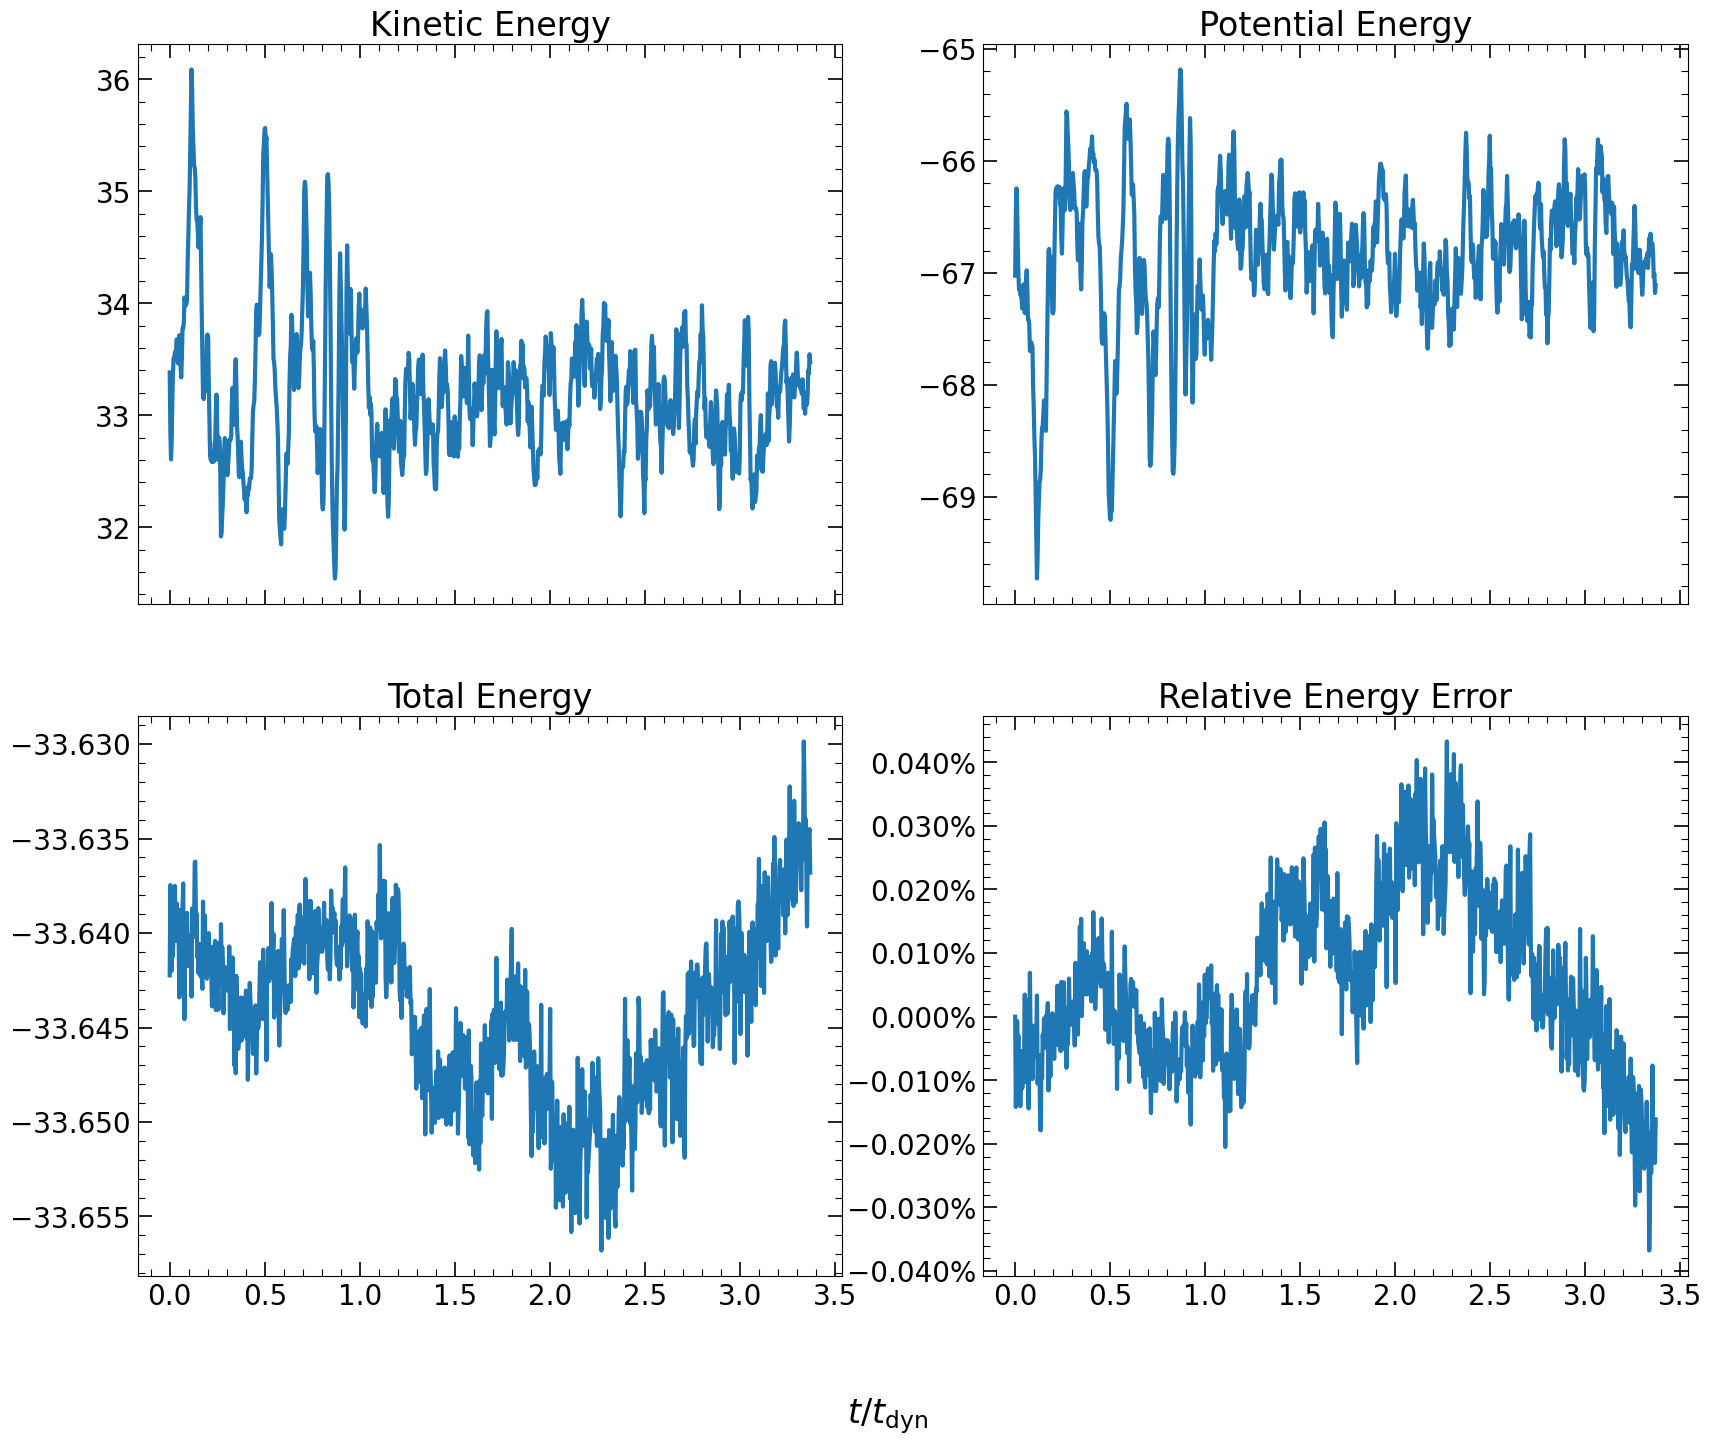

In [16]:
# ENERGY PLOTS

#----------------------------------------------------------------------
# These are ordered to match the Energy_keys
title_labels = ["Kinetic Energy", "Potential Energy", "Total Energy"]

n_rows = 2
n_col = 2

fig, axes = plt.subplots(n_rows, n_col, figsize=(20, 16), sharex=True)

fig.supxlabel(r'$t/t_\text{dyn}$')

index = 0 # Index to count cycles and break
for i in range(n_rows):
    for j in range(n_col):
        axes[i][j].set_title(title_labels[index])

        axes[i][j].plot(time_stamp / dyn_time, Energy[Energy_keys[index]])

        index +=1
        if index == 3:
            break

axes[1][1].set_title("Relative Energy Error")

axes[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(1))

axes[1][1].plot(time_stamp / dyn_time, Energy_rel_e)

figures.append(fig)
figures_names.append("energy")

plt.show()

In [17]:
# PARTICLES INSIDE LAGRANGIAN RADII

#------------------------------------------------------
# We want to count how many particles stay inside some lagrangian radii
# particle_distance_cm works like this: particle_distance_cm[particle_index][time_index]
particles_distance_cm = get_3D_vec(snapshots, 'all', 'pos', absval=1, rf='cm')

# Swap the axis in order to have particle_distance_cm[time_index][particle_index]
particles_distance_cm = np.swapaxes(particles_distance_cm, 0, 1)

In [18]:
# Define some lagrangian_radii using quantiles to be applied to the radii distribution
# We can do this because our particles have the same mass
lagrangian_radii_frac = [0.4, 0.5, 0.6]

# Compute the lagrangian radii at every time
# lagrangian_radii[r_index][time_index]
lagrangian_radii = np.quantile(particles_distance_cm, lagrangian_radii_frac, axis=1)

# Compute the time average of the lagrangian radii at every time
# mean_lagrangian_radii[r_index]
mean_lagrangian_radii = np.mean(lagrangian_radii, axis=1)

# Make colors of the lagrangian_radii. Use indexes to access them
# lr_colors[r_index]
lr_colors = ['lightsalmon', 'deepskyblue', 'orchid']

# Make labels for the lagrangian radii
lr_labels = [r'$q={0}$'.format(lagrangian_radii_frac[i])
             for i in range(len(lagrangian_radii_frac))]

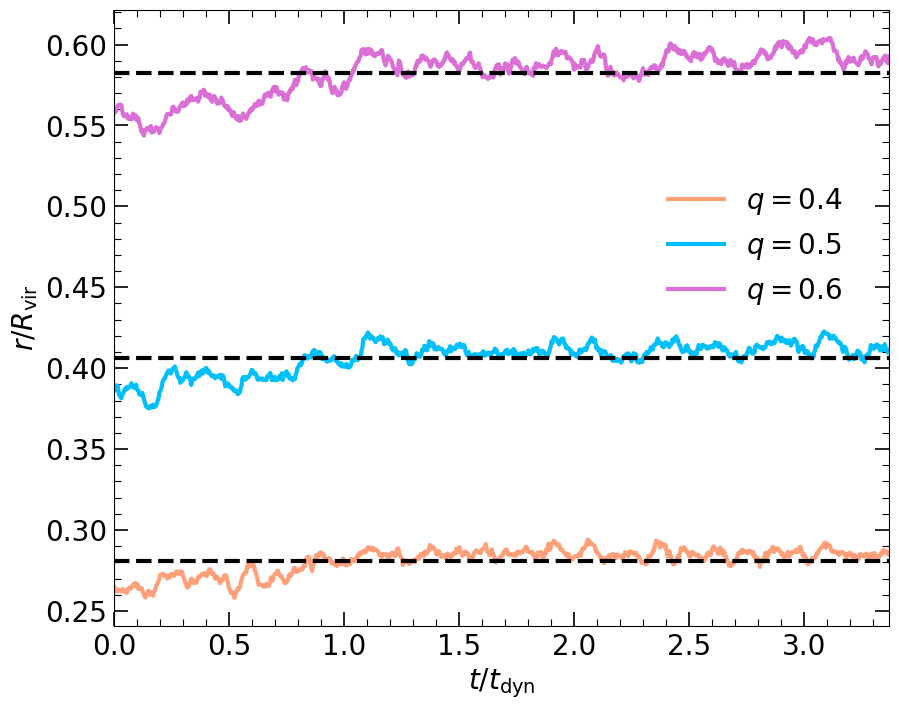

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r'$t/t_\text{dyn}$')
ax.set_ylabel(r'$r/R_\text{vir}$')

for lr, lr_mean, c, lb in zip(lagrangian_radii, mean_lagrangian_radii, lr_colors, lr_labels):
    ax.plot(time_stamp / dyn_time, lr / R_vir, color=c, label=lb)
    ax.axhline(lr_mean / R_vir, color='black', linestyle='--')

ax.autoscale(axis='x', tight=True)

ax.legend(loc=(0.7, 0.5))

figures.append(fig)
figures_names.append("lag_rad")

plt.show()

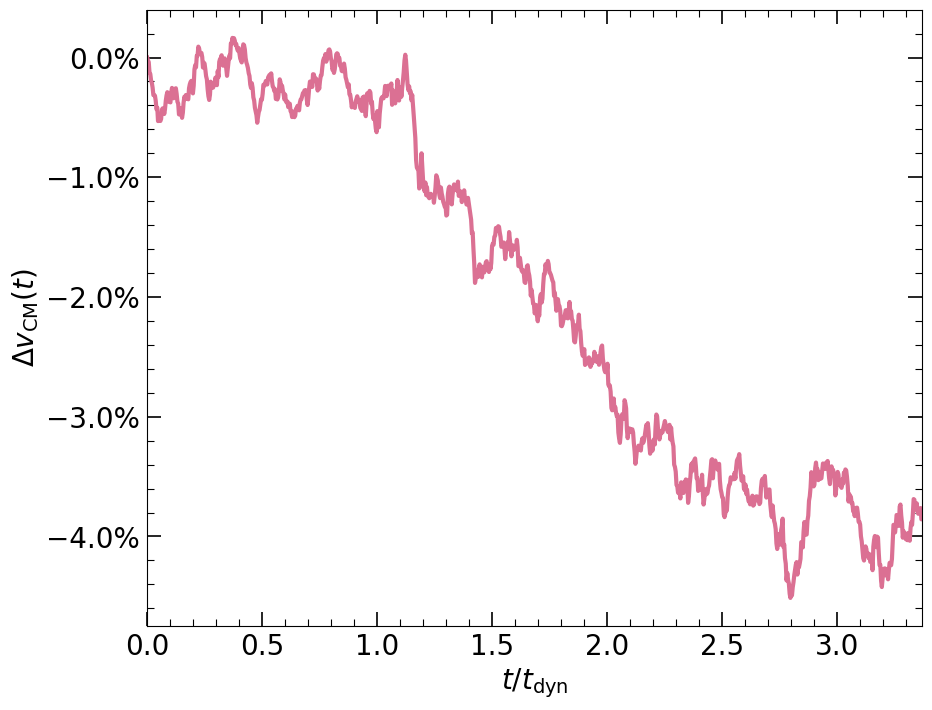

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r'$t/t_\text{dyn}$')
ax.set_ylabel(r'$\Delta v_{\text{CM}}(t)$')

ax.plot(time_stamp / dyn_time, (cm_vel_abs - cm_vel_abs[0]) / cm_vel_abs[0], color='palevioletred')

ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

ax.autoscale(axis='x', tight=True)

figures.append(fig)
figures_names.append("cm")

plt.show()

In [21]:
def primitive_quad(func, x_grid, *kwargs, lower_limit=None, upper_limit=None):
    if (type(lower_limit) == type(None) and type(upper_limit) == type(None)) or\
        (type(lower_limit) != type(None) and type(upper_limit) != type(None)):
        raise ValueError("Specify limits or use quad directly for integration on fixed intervals")
    if type(upper_limit) != type(None):
        return np.array([quad(func, x_inf, upper_limit, args=kwargs)[0] for x_inf in x_grid])
    elif type(lower_limit) != type(None):
        return np.array([quad(func, lower_limit, x_up, args=kwargs)[0] for x_up in x_grid])
    
def NFW_rho(r, rho_0, R_s):
    x = r / R_s
    return rho_0 / (x * (1 + x) ** 2)

def rho(r, rho_0, R_s, R_vir):
    x = r / R_vir
    return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)
    
def mass(r, rho_0, R_s, R_vir, value=False):
    if value:
        return quad(lambda r: (4 * np.pi * r ** 2) * rho(r, rho_0, R_s, R_vir), 0, r)[0]
    else:
        return primitive_quad(lambda r, rho_0, R_s, R_vir: (4 * np.pi * r ** 2) * rho(r, rho_0, R_s, R_vir),
                              r, rho_0, R_s, R_vir, lower_limit=0)

def potential(r, rho_0, R_s, R_vir, value=False):
    if value:
        return -(mass(r, rho_0, R_s, R_vir, value) / r +
                 4 * np.pi * quad(lambda r, rho_0, R_s, R_vir: r * rho(r, rho_0, R_s, R_vir),
                                  r, np.inf, args=(rho_0, R_s, R_vir))[0])
    else:
        return -(mass(r, rho_0, R_s, R_vir, value) / r +
                 4 * np.pi * primitive_quad(lambda r, rho_0, R_s, R_vir: r * rho(r, rho_0, R_s, R_vir),
                                            r, rho_0, R_s, R_vir, upper_limit=np.inf))
    
# Compute de potential derivative using the central difference method
def potential_derivative(r, rho_0, R_s, R_vir, value=False, h=1e-5):
    return (potential(r + h, rho_0, R_s, R_vir, value) - potential(r - h, rho_0, R_s, R_vir, value)) / (2 * h)

# Load the Distribution function model, if present
if os.path.exists("DF_model.pkl"):
    with open("DF_model.pkl", "rb") as model:
        kr = pickle.load(model)

# Distribution function f(E), where E = phi(r) + 0.5 * v^2 < 0
# The evaluation of this estimator is a bit expensive,
# therefore using it might take a while
def DF(E):
    if not np.iterable(E):
        return kr.predict([[E]])[0]
    else:
        return kr.predict(E[:, np.newaxis])

In [22]:
# vel_cm_abs works like this: vel_cm_abs[particle_index][time_index]
vel_cm_abs = get_3D_vec(snapshots, 'all', 'vel', absval=1, rf='cm')

# Swap the axis in order to have vel_cm_abs[time_index][particle_index]
vel_cm_abs = np.swapaxes(vel_cm_abs, 0, 1)

In [23]:
# I want the distance of the perturber from every particle at every time
# dist_from_pert works like this: dist_from_pert[particle_index][time_index]
dist_from_pert = get_3D_vec(snapshots, 'all', 'pos', absval=1, rf='particle', rf_arg=N-1)

# Swap the axis in order to have dist_from_pert[time_index][particle_index]
dist_from_pert = np.swapaxes(dist_from_pert, 0, 1)

# Mean distance of particles from the perturber at every time
mean_dist_from_pert = np.mean(dist_from_pert, axis=1)

In [24]:
# Get the position of all the particles with respect to the center of mass
# dist_from_pert works like this: dist_from_pert[particle_index][time_index]
particles_pos_cm = get_3D_vec(snapshots, 'all', 'pos', rf='cm')

# Swap the axis in order to have dist_from_pert[time_index][particle_index]
particles_pos_cm = np.swapaxes(particles_pos_cm, 0, 1)

In [25]:
# PERTURBER

#---------------------------------------------------
pert_mass = get_masses(snapshots, perturber_indexes)

# Absolute reference frame (0, 0, 0)
pos_pert = get_3D_vec(snapshots, perturber_indexes, 'pos', rf='snapshot')
dist_pert = compute_vector_abs(pos_pert.swapaxes(0, 1))
vel_pert = get_3D_vec(snapshots, perturber_indexes, 'vel', rf='snapshot')
vel_pert_abs = compute_vector_abs(vel_pert.swapaxes(0, 1))
acc_pert = np.gradient(vel_pert, time_stamp, axis=0)
acc_pert_abs = compute_vector_abs(acc_pert.swapaxes(0, 1))
l_pert = np.cross(pos_pert, vel_pert)
l_pert_abs = compute_vector_abs(l_pert.swapaxes(0, 1))

# CoM reference frame
pos_pert_cm = get_3D_vec(snapshots, perturber_indexes, 'pos', rf='cm')
dist_pert_cm = compute_vector_abs(pos_pert_cm.swapaxes(0, 1))
vel_pert_cm = get_3D_vec(snapshots, perturber_indexes, 'vel', rf='cm')
vel_pert_cm_abs = compute_vector_abs(vel_pert_cm.swapaxes(0, 1))
acc_pert_cm = np.gradient(vel_pert_cm, time_stamp, axis=0)
acc_pert_cm_abs = compute_vector_abs(acc_pert_cm.swapaxes(0, 1))
l_pert_cm = np.cross(pos_pert_cm, vel_pert_cm)
l_pert_cm_abs = compute_vector_abs(l_pert_cm.swapaxes(0, 1))

# Confidence level for the resolution of the angular momentum due to the smoothing length of the simulation
confidence_lower_l_pert_cm_circ_abs =  20 *\
    (smoothing_length ** 3 * potential_derivative(smoothing_length, rho_0, R_s, R_vir, value=True)) ** 0.5

# Maximum trusted index of the perturber
confidence_stop_index = np.where(l_pert_cm_abs <= confidence_lower_l_pert_cm_circ_abs)[0][0]

# Support vectors
pert_qty_list = [[pos_pert, vel_pert, acc_pert, l_pert],
                 [pos_pert_cm, vel_pert_cm, acc_pert_cm, l_pert_cm]]

pert_labels = [[r'$x$', r'$y$', r'$z$'],
               [r'$v_x$', r'$v_y$', r'$v_z$'],
               [r'$a_x$', r'$a_y$', r'$a_z$'],
               [r'$L_x$', r'$L_y$', r'$L_z$']]

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_88679/2178163531.py:16: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


In [26]:
l_pert_cm_circ_abs = np.zeros(len(time_stamp))

for E, index in tqdm(zip(particles_E_kin[:, perturber_indexes].squeeze() / pert_mass +
                         potential(dist_pert_cm, rho_0, R_s, R_vir),
                         range(len(time_stamp))), total=len(time_stamp)):
    if E >= 0:
        l_pert_cm_circ_abs[index] = np.nan
    else:
        r_c = find_root(lambda r: potential(r, rho_0, R_s, R_vir, value=True) +\
                        r * potential_derivative(r, rho_0, R_s, R_vir, value=True) / 2 - E,
                        (1e-3, 100 * R_vir))
        l_pert_cm_circ_abs[index] = (r_c.x ** 3 * potential_derivative(r_c.x, rho_0, R_s, R_vir, value=True)) ** 0.5

eta = l_pert_cm_abs / l_pert_cm_circ_abs

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_88679/2178163531.py:16: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)
100%|██████████| 1001/1001 [01:05<00:00, 15.21it/s]


In [27]:
# np.save("eta_data/eta_" + output_file_name.split("_")[2] + ".npy",
#         np.vstack([time_stamp[:confidence_stop_index] / dyn_time, eta[:confidence_stop_index]]))

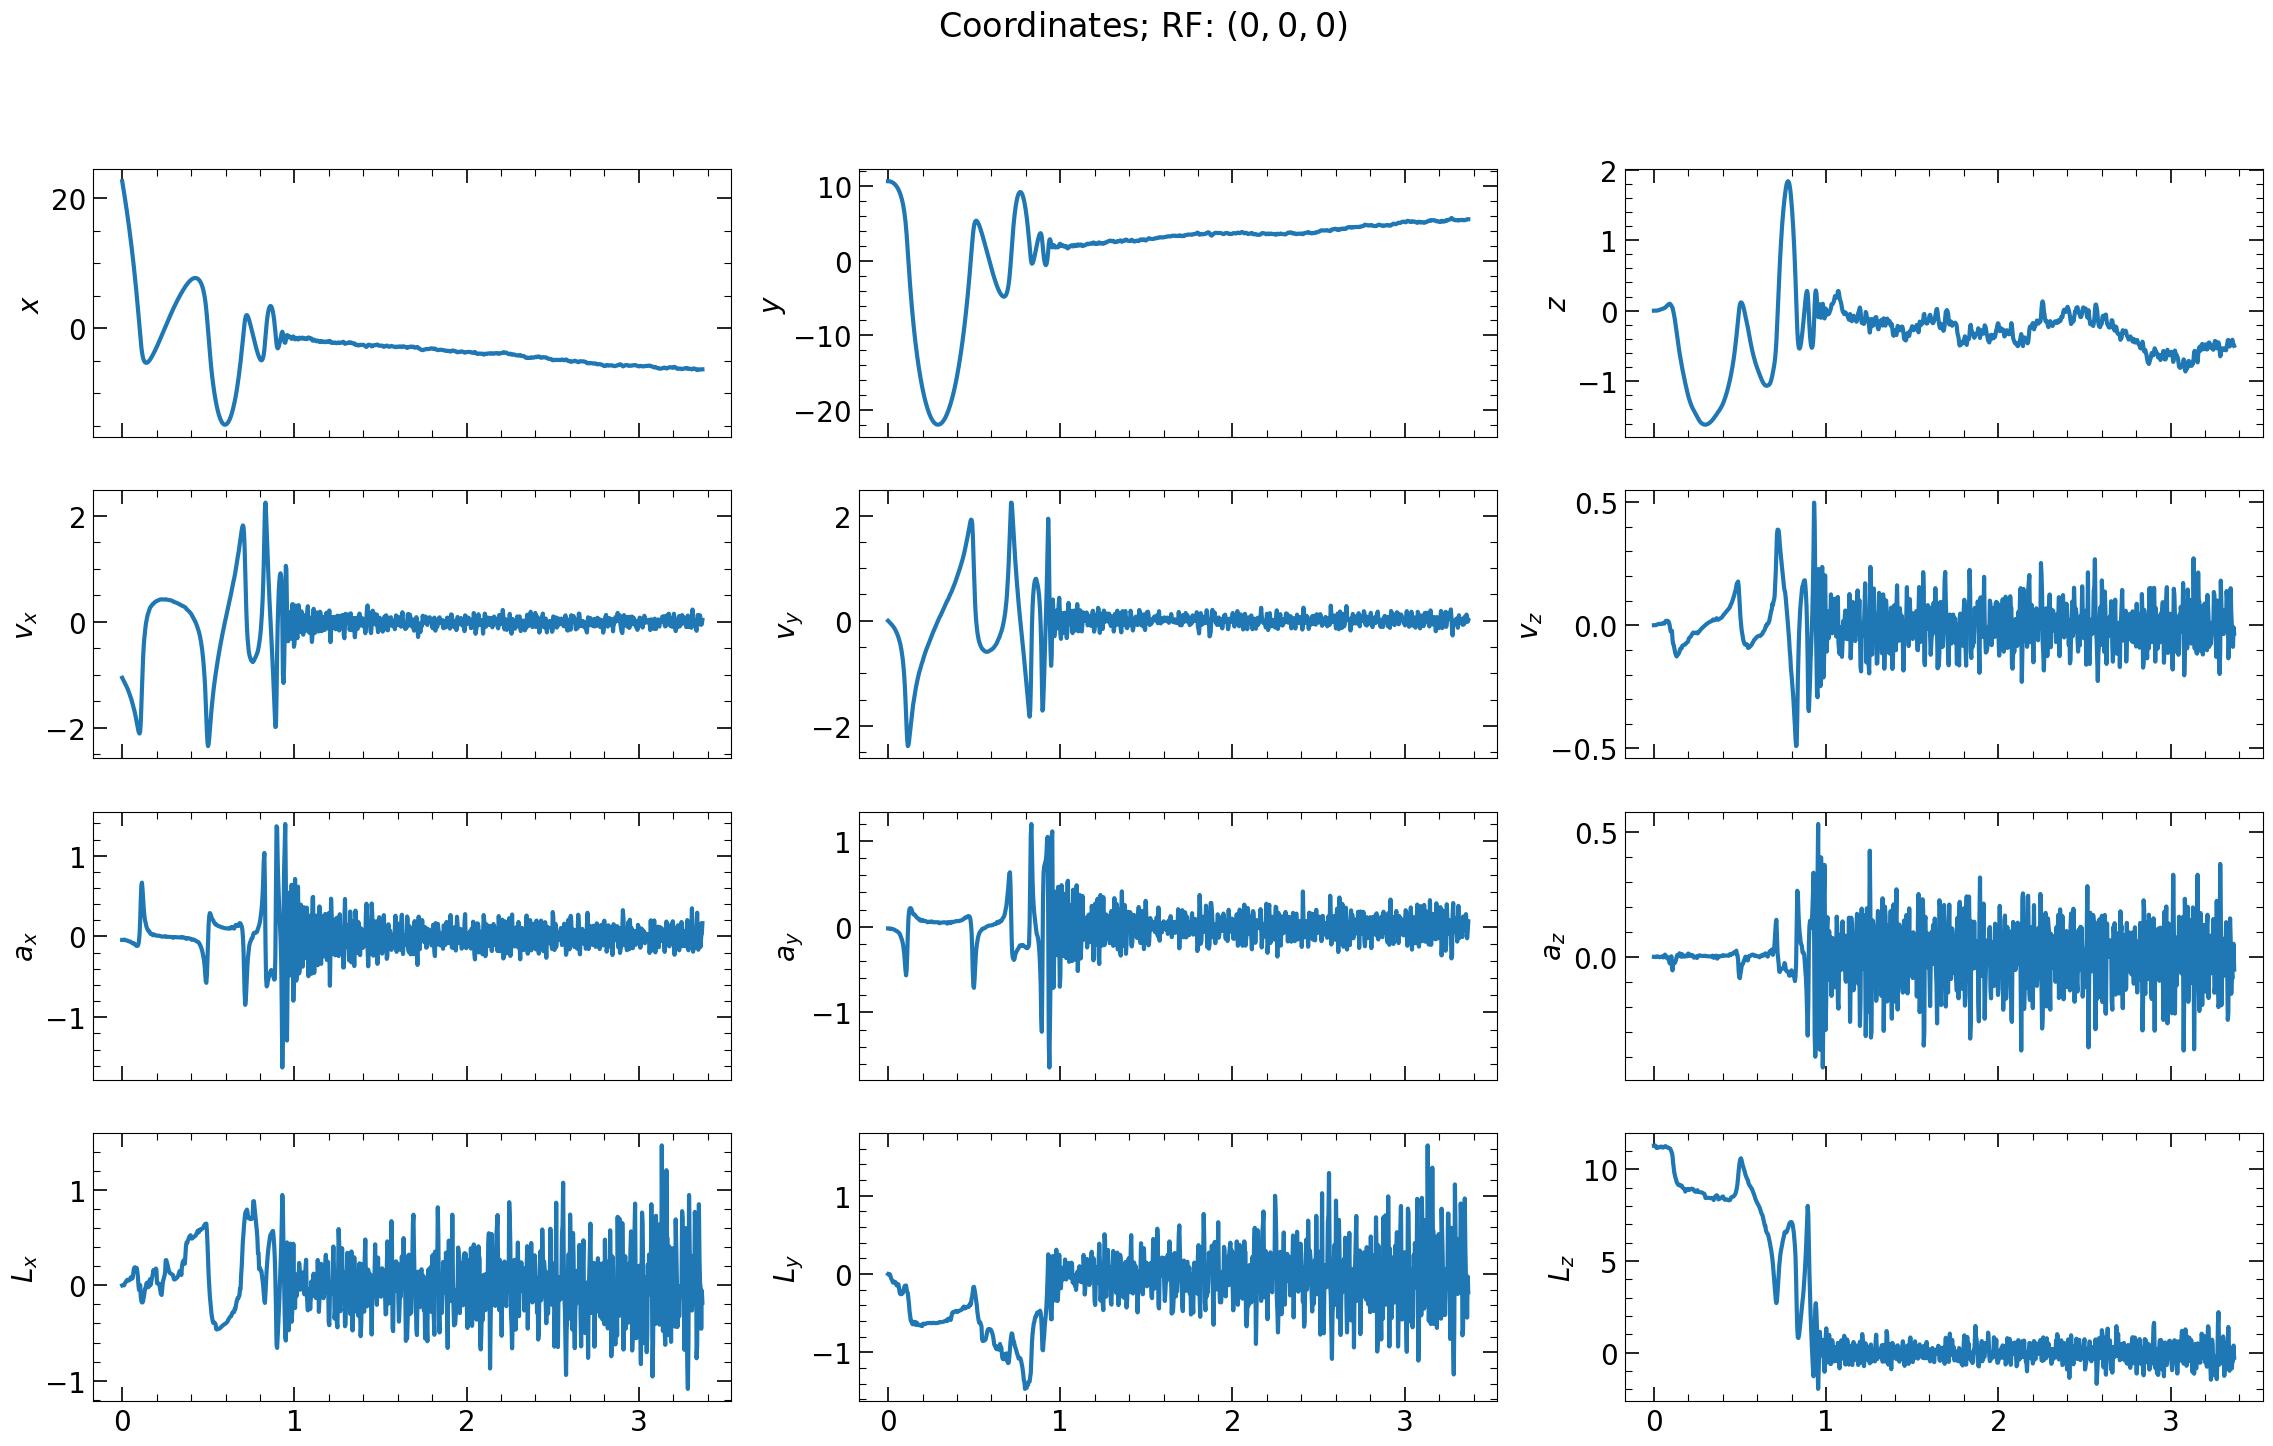

In [28]:
n_rows = 4

fig, axes = plt.subplots(n_rows, 3, figsize=(28, 16), sharex=True)

fig.suptitle(r"Coordinates; RF: $(0, 0, 0)$")

for row in range(n_rows):
    for ax, i in zip(axes[row], range(len(axes[row]))):
        ax.set_ylabel(pert_labels[row][i])
        ax.plot(time_stamp / dyn_time, pert_qty_list[0][row][:, i])

figures.append(fig)
figures_names.append("pert_000")

plt.show()

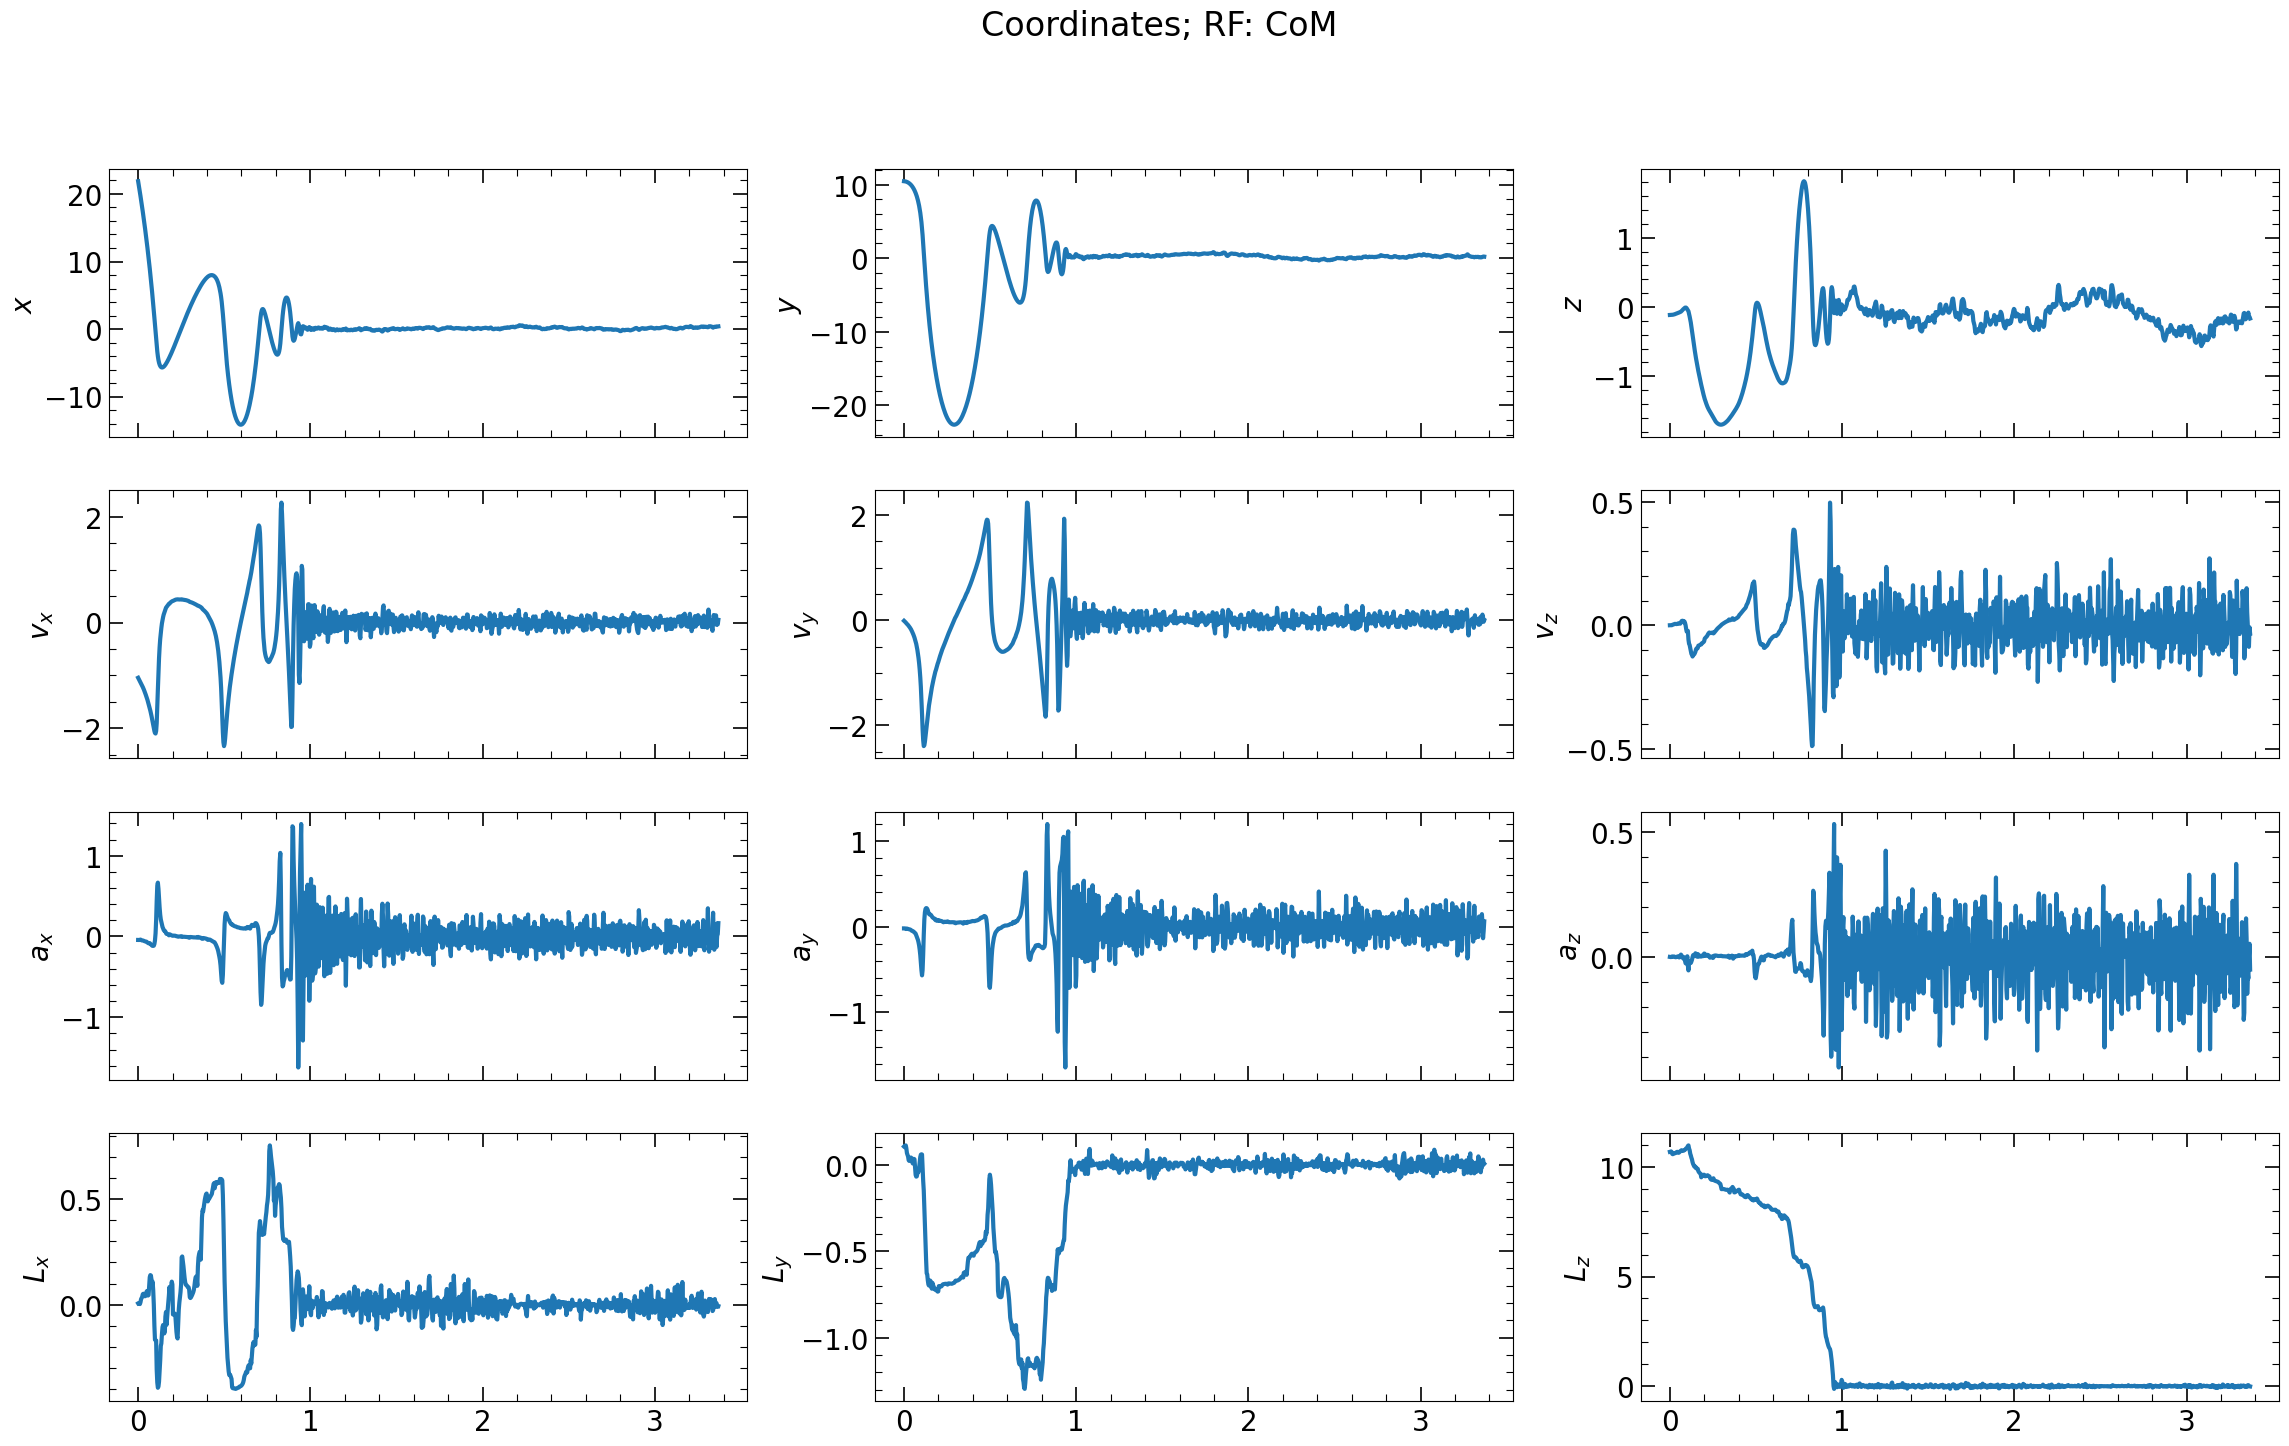

In [29]:
n_rows = 4

fig, axes = plt.subplots(n_rows, 3, figsize=(28, 16), sharex=True)

fig.suptitle("Coordinates; RF: CoM")

for row in range(n_rows):
    for ax, i in zip(axes[row], range(len(axes[row]))):
        ax.set_ylabel(pert_labels[row][i])
        ax.plot(time_stamp / dyn_time, pert_qty_list[1][row][:, i])

figures.append(fig)
figures_names.append("pert_cm")

plt.show()

$$\frac{d\overline{v}_M}{dt} = -16 \pi^2 (\ln\Lambda) G^2 m(M+m) \frac{1}{v^3_M} \int_0^{v_M} v^2 f(v) dv \overline{v}_M$$

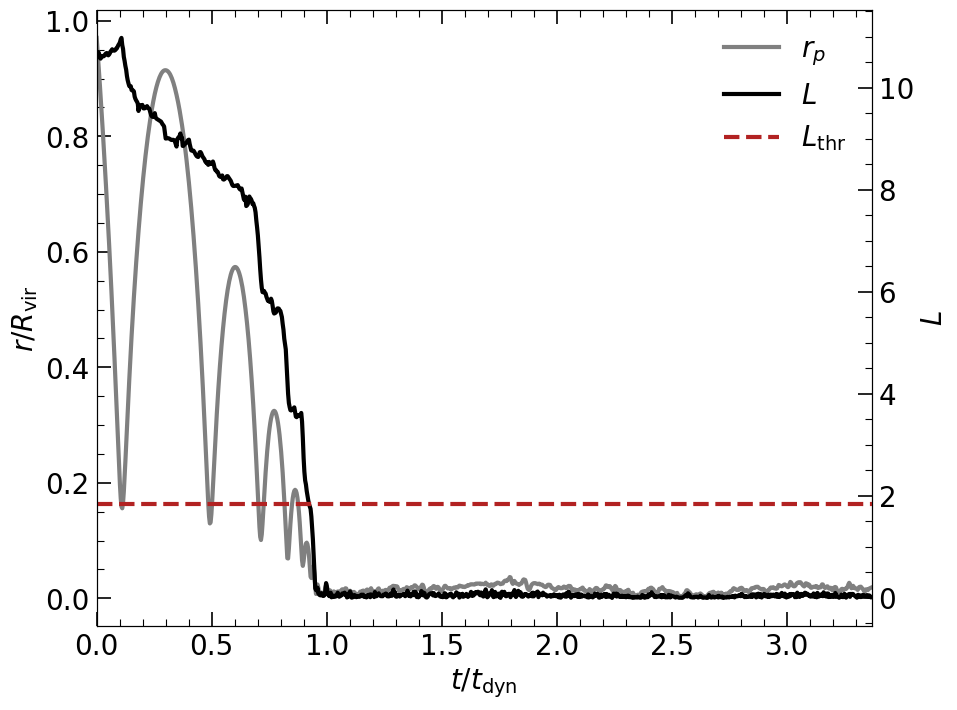

In [30]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

ax1.set_xlabel(r'$t/t_\text{dyn}$')
ax1.set_ylabel(r'$r/R_\text{vir}$')
ax2.set_ylabel(r'$L$')

lines = []

lines.append(ax1.plot(time_stamp / dyn_time, dist_pert_cm / R_vir, color='gray', label=r'$r_p$')[0])
lines.append(ax2.plot(time_stamp / dyn_time, l_pert_cm_abs, color='black', label=r'$L$')[0])

lines.append(ax2.axhline(confidence_lower_l_pert_cm_circ_abs, color='firebrick', linestyle='--', label=r'$L_\text{thr}$'))

ax1.autoscale(axis='x', tight=True)

ax1.legend(handles=lines)

figures.append(fig)
figures_names.append("pert_dist_l")

plt.show()

In [31]:
expected_dissipative_acc_pert_cm_abs = np.zeros(len(time_stamp))

m = get_masses(snapshots, 0)
# const miss an 'm' because my distribution function is calibrated
# on the mass density, not the number density (i.e. divide by the particle
# mass to get the number density distribution after the integration
const = 16 * np.pi ** 2 * (pert_mass + m)

In [32]:
# # USING LOCAL VELOCITY DISTRIBUTION

# local_frac = 0.1
# n_particles = int(len(background_indexes) * local_frac)

# # n_particles = 100

# for time_index in tqdm(range(len(time_stamp))):
#     # Select the n_particles closest to the perturber
#     n_particles_indexes = np.argsort(dist_from_pert[time_index][background_indexes])[:n_particles]

#     # Define the radius from the perturber that contains n_particles
#     R = dist_from_pert[time_index][background_indexes][n_particles_indexes[-1]]
#     V = 4 * np.pi * R ** 3 / 3

#     # Compute the number denisty inside the sphere
#     n_density = n_particles / V

#     # Select the velocities of the n_particles and plot their distribution
#     y, x, _ = plt.hist(vel_cm_abs[time_index][background_indexes][n_particles_indexes], bins='auto', density=True, histtype='step')
#     plt.close()

#     # Compute the expected acceleration
#     i = np.where(x[:-1] > vel_pert_cm_abs[time_index])[0][0]

#     expected_dissipative_acc_pert_cm_abs[time_index] = n_density * const *\
#         np.trapezoid(np.log(dist_from_pert[time_index][background_indexes][n_particles_indexes[-1]] / dist_from_pert[time_index][background_indexes][n_particles_indexes[0]]) *\
#                      y[:i] * x[:i] ** 2, x[:i]) /\
#                         (vel_pert_cm_abs[time_index] ** 2)

In [33]:
# USING THE NUMERICAL DF
import warnings

# Catch warnings (print statements are very expensive)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    cl = np.zeros(len(time_stamp))

    for time_index in tqdm(range(len(time_stamp))):
        b_max = dist_pert_cm[time_index]
        b_min = max((pert_mass + m) / vel_pert_cm_abs[time_index] ** 2, smoothing_length) * (dist_pert_cm[time_index] / R_vir)
        cl[time_index] = np.log(b_max / b_min)
        expected_dissipative_acc_pert_cm_abs[time_index] = const * cl[time_index] *\
            quad(lambda x: DF(0.5 * x ** 2 + potential(dist_pert_cm[time_index], rho_0, R_s, R_vir, value=True)) * x ** 2,
                0, vel_pert_cm_abs[time_index])[0] / vel_pert_cm_abs[time_index] ** 2

100%|██████████| 1001/1001 [03:18<00:00,  5.04it/s]


$$a_{grav} = -\hat{r} \frac{d\phi}{dr}$$

In [34]:
# Now I want to retrieve the friction from the data by subtracting
# the gravitational (central) acceleration from the total one

# Compute the radial versor. Swapping axes in a necessary intermediate step to make
# the arrays broadcastable
radial_cm_versor = (pos_pert_cm.swapaxes(0, 1) / dist_pert_cm).swapaxes(0, 1)

# Compute the central acceleration
central_acc_pert_cm = (-radial_cm_versor.swapaxes(0, 1) * potential_derivative(dist_pert_cm, rho_0, R_s, R_vir)).swapaxes(0, 1)

# Compute the dissipative component of the acceleration by subctracting
# the central component from the total acceleration
dissipative_acc_pert_cm = acc_pert_cm - central_acc_pert_cm

# Compute the the absolite value of the dissipative component of the acceleration
dissipative_acc_pert_cm_abs = compute_vector_abs(dissipative_acc_pert_cm.swapaxes(0, 1))

/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_88679/2178163531.py:16: RuntimeWarning: overflow encountered in sinh
  return NFW_rho(r, rho_0, R_s) * x / np.sinh(x)


In [35]:
# Also compute the vectortial expected acceleration (opposite to the perturber velocity)
expected_dissipative_acc_pert_cm = -((expected_dissipative_acc_pert_cm_abs / vel_pert_cm_abs) *\
                                     vel_pert_cm.swapaxes(0, 1)).swapaxes(0, 1)

# Compute the expected torque due to dissipative forces
expected_torque_pert_cm = np.cross(pos_pert_cm, expected_dissipative_acc_pert_cm)

In [36]:
expected_l_pert_cm_evolution = np.zeros(shape=(len(time_stamp), 3))

expected_l_pert_cm_evolution[0] = l_pert_cm[0]

for i, l, t in zip(range(len(time_stamp)), l_pert_cm, expected_torque_pert_cm):
    if i + 1 == len(time_stamp):
        break
    time_step = time_stamp[i+1] - time_stamp[i]
    expected_l_pert_cm_evolution[i+1] = l + t * time_step

expected_l_pert_cm_evolution_abs = compute_vector_abs(expected_l_pert_cm_evolution.swapaxes(0, 1))

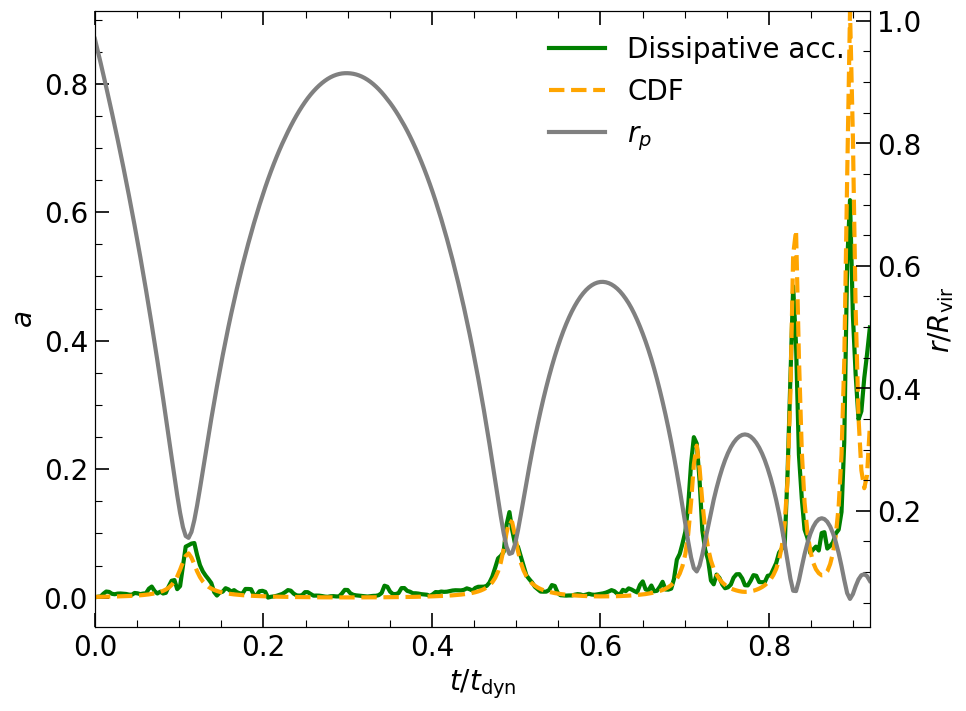

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# RF: Center of mass
ax1.set_xlabel(r'$t/t_\text{dyn}$')
ax1.set_ylabel(r'$a$')
ax2.set_ylabel(r'$r/R_\text{vir}$')

lines = []

lines.append(ax1.plot(time_stamp[:confidence_stop_index] / dyn_time, dissipative_acc_pert_cm_abs[:confidence_stop_index],
                      color='green', label="Dissipative acc.")[0])
lines.append(ax1.plot(time_stamp[:confidence_stop_index] / dyn_time, expected_dissipative_acc_pert_cm_abs[:confidence_stop_index],
                      color='orange', linestyle='--', label="CDF")[0])

lines.append(ax2.plot(time_stamp[:confidence_stop_index] / dyn_time, dist_pert_cm[:confidence_stop_index] / R_vir,
                      color='gray', label=r'$r_p$')[0])

ax1.autoscale(axis='x', tight=True)
ax1.set_ylim(ax1.get_ylim()[0], max(np.max(dissipative_acc_pert_cm_abs[:confidence_stop_index]),
                                      np.max(expected_dissipative_acc_pert_cm_abs[:confidence_stop_index])))

ax1.legend(handles=lines, loc='upper right')

figures.append(fig)
figures_names.append("pert_acc_cdf")

plt.show()

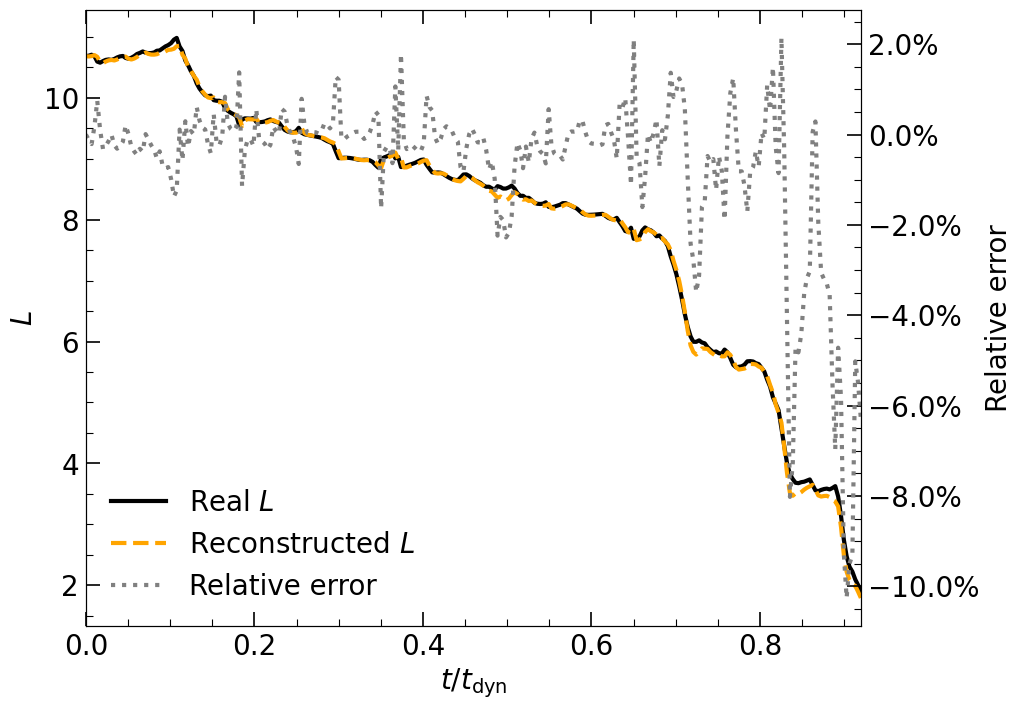

In [38]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# RF: Center of mass
ax1.set_xlabel(r'$t/t_\text{dyn}$')
ax1.set_ylabel(r'$L$')
ax2.set_ylabel('Relative error')
ax2.yaxis.set_major_formatter(ticker.PercentFormatter(1))

lines = []

lines.append(ax1.plot(time_stamp[:confidence_stop_index] / dyn_time, l_pert_cm_abs[:confidence_stop_index],
                      color='black', label=r'Real $L$')[0])
lines.append(ax1.plot(time_stamp[:confidence_stop_index] / dyn_time, expected_l_pert_cm_evolution_abs[:confidence_stop_index],
                      color='orange', linestyle='--', label=r'Reconstructed $L$')[0])

lines.append(ax2.plot(time_stamp[:confidence_stop_index] / dyn_time, ((expected_l_pert_cm_evolution_abs - l_pert_cm_abs) / l_pert_cm_abs)[:confidence_stop_index],
                      color='gray', linestyle=':', label='Relative error')[0])

ax1.legend(handles=lines, loc='lower left')

ax1.autoscale(axis='x', tight=True)

figures.append(fig)
figures_names.append("pert_l_cdf")

plt.show()

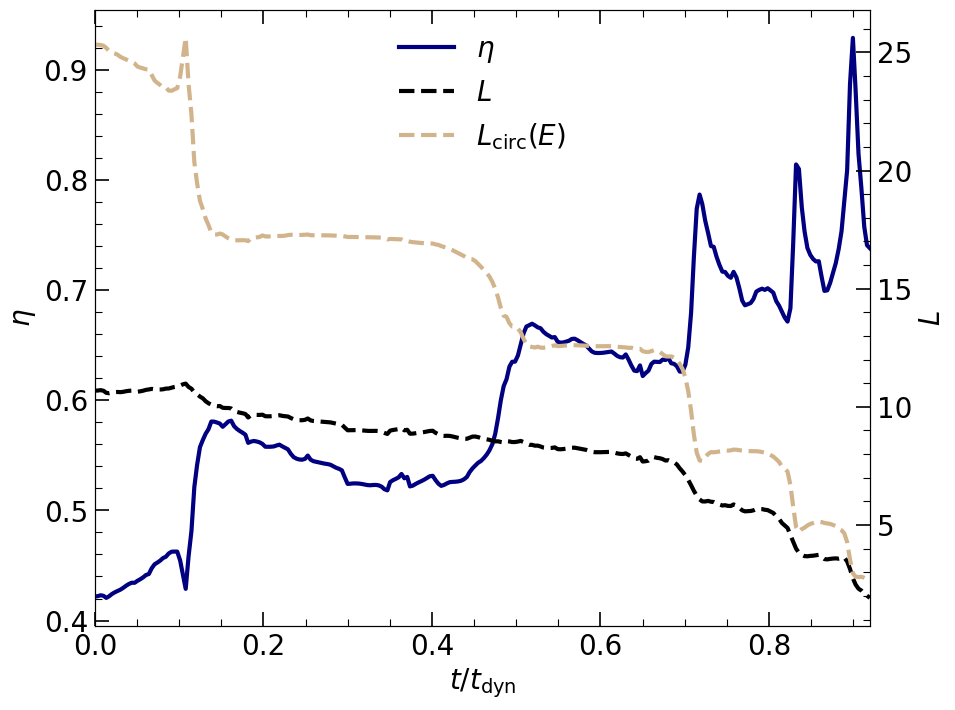

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# Circularity
ax1.set_xlabel(r'$t/t_\text{dyn}$')
ax1.set_ylabel(r'$\eta$')
ax2.set_ylabel(r'$L$')

lines = []

lines.append(ax1.plot(time_stamp[:confidence_stop_index] / dyn_time, eta[:confidence_stop_index],
                      color='navy', label=r'$\eta$')[0])
lines.append(ax2.plot(time_stamp[:confidence_stop_index] / dyn_time, l_pert_cm_abs[:confidence_stop_index],
                      color='black', linestyle='--', label=r'$L$')[0])
lines.append(ax2.plot(time_stamp[:confidence_stop_index] / dyn_time, l_pert_cm_circ_abs[:confidence_stop_index],
                      color='tan', linestyle='--', label=r'$L_\text{circ}(E)$')[0])

ax1.autoscale(axis='x', tight=True)

ax1.legend(handles=lines, loc='upper center')

figures.append(fig)
figures_names.append("pert_l_circ")

plt.show()

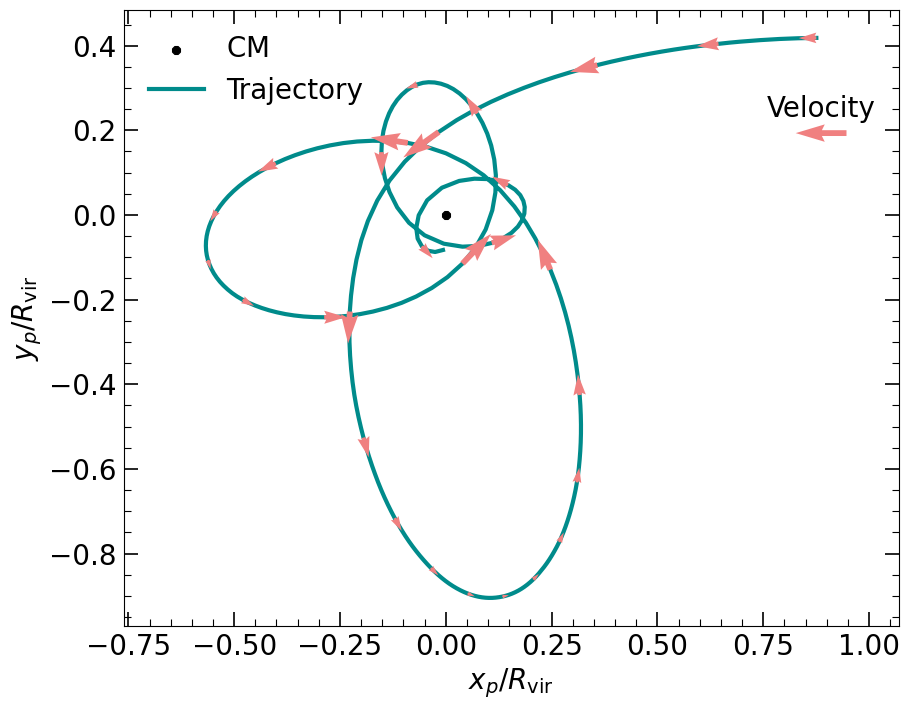

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))

final_index = confidence_stop_index
step_pos = 1
step_vel = 10
scale_vel = R_vir

ax.set_xlabel(r'$x_p/R_\text{vir}$')
ax.set_ylabel(r'$y_p/R_\text{vir}$')

ax.scatter(0, 0, color='black', marker='8', label=r'$\text{CM}$')
ax.plot(pos_pert_cm[:final_index:step_pos, 0] / R_vir, pos_pert_cm[:final_index:step_pos, 1] / R_vir,
        color='darkcyan', label='Trajectory')
qvr_vel = ax.quiver(pos_pert_cm[:final_index:step_vel, 0] / R_vir, pos_pert_cm[:final_index:step_vel, 1] / R_vir,
                    vel_pert_cm[:final_index:step_vel, 0], vel_pert_cm[:final_index:step_vel, 1],
                    color='lightcoral', angles='xy', scale_units='xy', scale=scale_vel, zorder=2)

ax.set_aspect('equal', 'datalim')

ax.quiverkey(qvr_vel, 0.9, 0.8, -3, label='Velocity')

ax.legend()

figures.append(fig)
figures_names.append("pert_trajectory")

plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


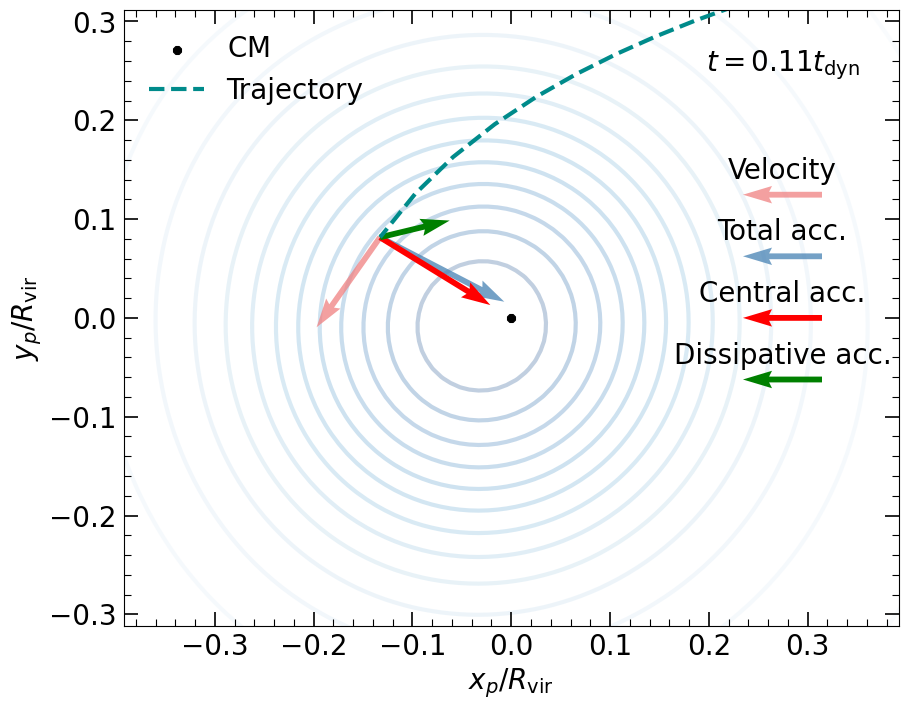

In [41]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_xlabel(r'$x_p/R_\text{vir}$')
ax.set_ylabel(r'$y_p/R_\text{vir}$')

# Control parameters
initial_index = 1
final_index = signal.find_peaks(-dist_pert_cm)[0][0]
scale_vel = R_vir
scale_acc_factor = 5
scale_acc = R_vir / scale_acc_factor

scale_acc_dissipative_factor = 5

# Trajectory
ax.scatter(0, 0, color='black', marker='8', label=r'$\text{CM}$')
ax.plot(pos_pert_cm[initial_index:final_index + 1, 0] / R_vir, pos_pert_cm[initial_index:final_index + 1, 1] / R_vir,
        color='darkcyan', linestyle='--', label='Trajectory')

# Arrows
qvr_vel = ax.quiver(pos_pert_cm[final_index, 0] / R_vir, pos_pert_cm[final_index, 1] / R_vir,
                    vel_pert_cm[final_index, 0], vel_pert_cm[final_index, 1],
                    color='lightcoral', angles='xy', scale_units='xy', scale=scale_vel, alpha=0.75)
qvr_acc = ax.quiver(pos_pert_cm[final_index, 0] / R_vir, pos_pert_cm[final_index, 1] / R_vir,
                    acc_pert_cm[final_index, 0], acc_pert_cm[final_index, 1],
                    color='steelblue', angles='xy', scale_units='xy', scale=scale_acc, alpha=0.75)
qvr_central_acc = ax.quiver(pos_pert_cm[final_index, 0] / R_vir, pos_pert_cm[final_index, 1] / R_vir,
                            central_acc_pert_cm[final_index, 0], central_acc_pert_cm[final_index, 1],
                            color='red', angles='xy', scale_units='xy', scale=scale_acc)
qvr_dissipative_acc = ax.quiver(pos_pert_cm[final_index, 0] / R_vir, pos_pert_cm[final_index, 1] / R_vir,
                                dissipative_acc_pert_cm[final_index, 0], dissipative_acc_pert_cm[final_index, 1],
                                color='green', angles='xy', scale_units='xy', scale=scale_acc / scale_acc_dissipative_factor)

boundary_length = dist_pert_cm[final_index] / R_vir

# Contour levels for density
from scipy.stats import gaussian_kde

kde = gaussian_kde(particles_pos_cm[0].swapaxes(0, 1)[0:2, :] / R_vir)

x = np.linspace(-3 * boundary_length, 3 * boundary_length, 100)
y = np.linspace(-3 * boundary_length, 3 * boundary_length, 100)

x, y = np.meshgrid(x, y) # x, y both 2D
z = kde(np.vstack([x.flatten(), y.flatten()])) # stacks on axis 0
z = z.reshape(x.shape) # result from kde is 1D with x times y length

ax.contour(x, y, z, levels=15, cmap='Blues', alpha=0.25, zorder=0)

# Time annotation
ax.text(0.95, 0.9,
        r'$t={0} t_\text{{dyn}}$'.format(np.format_float_positional(time_stamp[final_index] / dyn_time, 2)),
        transform=ax.transAxes, horizontalalignment='right')

# Axes formatting
ax.set_xlim(-2 * boundary_length, 2 * boundary_length)
ax.set_ylim(-2 * boundary_length, 2 * boundary_length)

ax.set_aspect('equal', 'datalim')

# Legend formatting
key_scale = 2
ax.quiverkey(qvr_vel, 0.85, 0.7, -key_scale, label='Velocity')
ax.quiverkey(qvr_acc, 0.85, 0.6, -key_scale / scale_acc_factor, label='Total acc.')
ax.quiverkey(qvr_central_acc, 0.85, 0.5, -key_scale / scale_acc_factor, label='Central acc.')
ax.quiverkey(qvr_dissipative_acc, 0.85, 0.4, -key_scale / scale_acc_factor / scale_acc_dissipative_factor, label='Dissipative acc.')

ax.legend()

figures.append(fig)
figures_names.append("pert_snapshot_forces")

plt.show()

In [42]:
# IMAGE SAVER

#------------------------------------------------------------

# Toggle on/off the image saver
save_images = False

# dpi of the images
dpi = 300

if save_images:
    # FOLDERS MANAGING

    #-------------------------------------------------------------------------
    # File paths variables
    images_dir_path = "images"

    # Create folders to store the images
    if not os.path.isdir(images_dir_path):
        os.makedirs(images_dir_path)
    
    # Empty the 'images' folder
    for file_name in os.listdir(images_dir_path):
        file_path = os.path.join(images_dir_path, file_name)
        os.remove(file_path)

    #---------------------------------------------------------------------
    # SAVING IMAGES
    for figure_index in range(len(figures)):
        figures[figure_index].savefig(os.path.join(images_dir_path, figures_names[figure_index]),
                                      dpi=dpi, bbox_inches='tight')

In [43]:
# MOVIE MAKER

#------------------------------------------------------------------------

# Toggle on/off the movie maker
make_movie = False

if make_movie:
    # FOLDERS MANAGING

    #-------------------------------------------------------------------------
    # File paths variables
    movie_dir_path = "movie"
    frames_dir_path = os.path.join(movie_dir_path, "frames")
    movie_frame_name_prefix = "snapshot_img_"
    movie_name = "movie.mp4"

    # Create folders to store the movie and its frames
    if not os.path.isdir(movie_dir_path):
        os.makedirs(frames_dir_path)
    
    # Empty the 'frames' folder
    for file_name in os.listdir(frames_dir_path):
        file_path = os.path.join(frames_dir_path, file_name)
        os.remove(file_path)
    
    # Empty the 'movie' folder
    for file_name in os.listdir(movie_dir_path):
        file_path = os.path.join(movie_dir_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
    
    #------------------------------------------------------------------------
    # GENERATING FRAMES

    #------------------------------------------------------------------------
    # Rough estimate of the number of frames of the movie
    # Lowering it increases the step between snapshots that are considered
    # Use in a cycle below. If N_frames = len(snapshots) all frames are used
    N_frames = len(snapshots)
    
    # If True, frames will be deleted after the movie has been assembled
    delete_frames = True

    # In order to efficiently plot data with the purpose of making a movie is useful
    # to swap the axis of the array. This is not necessary, but otherwise plotting fucntions
    # would take a lot of time to run
    # "image_pos" works like this: new_pos[time_index][coordinate_index][particle_index]
    # So image_pos[time_index][coordinate_index] gives the values of the specified
    # coordinate at the specified time for all particles
    image_pos = np.swapaxes(pos, 0, 1) # Swap particle and time
    image_pos = np.swapaxes(image_pos, 1, 2) # Swap particle and coordinate

    # Initialize a list to store the colors of each particle at any time
    particles_colors = []

    color_cm = 'black'
    color_per = 'red'

    #-------------------------------------------------------------------------
    # Get minimum and maximum energy to normalize the colormap
    E_k_min = np.min(particles_E_kin)
    E_k_max = np.max(particles_E_kin)

    # Initialize a 3D plot
    fig = plt.figure(figsize=(16, 9))

    # computed_zorder=False is to allow manual setting of the order of the plots
    ax = fig.add_subplot(projection='3d', computed_zorder=False)
    ax.set_box_aspect(None, zoom=0.9) # To prevent z axis label to be cut off

    # For every snapshot (or for some of them depending of the step of the range() call)
    # plot the positon of every particle in 3D space
    for time_index in tqdm(range(0, len(snapshots), int(len(snapshots) / N_frames)), leave=False):
        # Plot the points and save the returned value from scatter() to make a colorbar
        p_plot = ax.scatter(image_pos[time_index][0], image_pos[time_index][1], image_pos[time_index][2],
                            zorder=0, c=particles_E_kin[time_index], alpha=0.8,
                            norm=colors.LogNorm(E_k_min, E_k_max), cmap=plt.colormaps.get_cmap('Blues'))
        ax.scatter(cm_pos[time_index][0], cm_pos[time_index][1], cm_pos[time_index][2],
                   color=color_cm, zorder=1)
        
        # Perturber
        ax.scatter(image_pos[time_index][0][perturber_indexes],
                   image_pos[time_index][1][perturber_indexes],
                   image_pos[time_index][2][perturber_indexes], zorder=2, color=color_per)
        
        # Plot the colorbar
        cb = fig.colorbar(p_plot, ax=ax, location='right', shrink=0.75)
        cb.set_label(r"$E_{kin}$", fontsize=15)
        
        # For the first snapshot register the axes limit
        if time_index == 0:
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
            z_lim = ax.get_zlim()
        
        # Set e cubic plot for every snapshot and fix the axes limit to the initial ones
        ax.set_aspect('equal', 'datalim')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_zlim(z_lim)

        # Set the snapshot time stamp as the title of every plot
        t = float(np.format_float_scientific(time_stamp[time_index], 2))
        ax.set_title(r"$t={t}$".format(t=t))
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        ax.set_zlabel(r"$z$")

        # Save the current figure with a proper name
        # zfill() is needed to achieve alphanumerical order later
        frame_name = movie_frame_name_prefix + str(time_index).zfill(5) + ".png"
        frame_path = os.path.join(frames_dir_path, frame_name)
        fig.savefig(frame_path)

        # Remove the colorbar and clear the axes
        cb.remove()
        ax.clear()

        # Close the current plot
        plt.close()

    #--------------------------------------------------------------------
    # ASSEMBLING FRAMES

    #--------------------------------------------------------------------
    # Get all the files in the frames directory and sort them in alphanumerical order
    movie_img_files = os.listdir(frames_dir_path)
    movie_img_files = sorted(movie_img_files)

    movie_path = os.path.join(movie_dir_path, movie_name)

    # Use the imageio writer to build the movie by appending to it every frame
    # Default fps is 10. 'I' stands for 'multiple images'
    with iio.get_writer(movie_path, mode='I', fps=10) as writer:
        for filename in movie_img_files:
            image = iio.imread(os.path.join(frames_dir_path, filename)) # Get the frame
            writer.append_data(image) # Append the frame
            
    # Delete individual frames if requested
    if delete_frames:
        for file_name in movie_img_files:
            file_path = os.path.join(frames_dir_path, file_name)
            os.remove(file_path)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 900) to (1600, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
